In [1]:
###############################################################################
#                          Libraries to use
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patheffects as path_effects
import pandas as pd
import csv

#!pip install pyswarm
#!pip install lmfit
from pyswarm import pso
from lmfit import (Minimizer, minimize, Parameters, Parameter, report_fit, 
                   fit_report)
from scipy.integrate import odeint
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from pylab import *

In [2]:
## Note that pandas automatically outputs a dataframe a la R,
## only no slicing indexing allowed.  To do that, you must coerce
## to an array.

#data_url = 'https://raw.githubusercontent.com/alexbbrummer/car_T/master/cart_dex_mean_sd_gbm_single_line.csv'
pbt_1_2_data_url = "../data/pbt_second_round/car_T_dex_pbt1_pbt2_lines.csv"
pbt_3_4_data_url = "../data/pbt_second_round/car_T_dex_pbt3_pbt4_lines.csv"


pbt_full_fits_url = "../car_T_notebooks/third_round_exports/pbt_1_2_4_fit_report_file_expdex_timeshift.csv"


pbt_1_2_data = pd.read_csv(pbt_1_2_data_url)
pbt_3_4_data = pd.read_csv(pbt_3_4_data_url)
pbt_full_fits = pd.read_csv(pbt_full_fits_url)

In [3]:
###############################################################################
#                     T-cell with Dex
###############################################################################
###############################################################################
#                     ODE system Model re-writing
#       currently hardcoded for modeling with t cells using non T cell fit
#       values.  Uses try/except to toggle use with lmfit (the try) or pyswarm
 #      (the exception)
###############################################################################

def f_dt(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    #Use condition on length of ps to toggle different return functions
    #if len(ps) == 2, no dex, no t cell
    #if len(ps) == 3, no t cell
    try:
        # this try allows us to run the lmfit
        rho = ps['rho'].value
        kappainv = ps['kappainv'].value
        c0 = ps['c0'].value
        kappac1 = ps['kappac1'].value
        kappac2 = ps['kappac2'].value
        theta = ps['theta'].value
        c3 = ps['c3'].value
    except:
        # This exception allows us to run the particle swarm optimization
        if len(ps) == 3:
            # define result_growth_gd_now variable within loop that
            # calls this block.
            rho = result_growth_gd_now.params['rho'].value
            kappainv = result_growth_gd_now.params['kappainv'].value
            c0 = result_growth_gd_now.params['c0'].value
            theta = result_tcell.params['theta'].value
            kappac1, kappac2, c3 = ps
        elif len(ps) == 6:
            rho, kappainv, c0, kappac1, kappac2, thetac3 = ps
        elif len(ps) == 7:
            rho, kappainv, c0, kappac1, kappac2, theta, c3 = ps

    x, y = xs
    
    if len(ps)==6:
        return (rho*x - rho*x*x*kappainv - c0*x - kappac1*x*y,
            kappac2*x*y - thetac3*y)
    elif len(ps)==7:
        return (rho*x - rho*x*x*kappainv - c0*np.exp(-(t-t_start)*np.log(2)/3.33)*x - kappac1*x*y,
                kappac2*x*y - (theta+c3*np.exp(-(t-t_start)*np.log(2)/3.33))*y)

def g_dt(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_dt, x0, t, args=(ps, t_start))
    return x

def rms_dt(ps, *args):
    x0, ts, data = args
    model = g_dt(ts, x0, ps)
    res = (model[:,0] - data).ravel()
    rms = np.sqrt(np.mean(res**2))
    return rms

def residual_dt(ps, *args):
    x0, ts, data = args
    model = g_dt(ts, x0, ps)
    return (model[:,0] - data).ravel()

def dex_decay(t, dex_max, t_start):
    return dex_max*(np.exp(-(t-t_start)*np.log(2)/3.33))

In [4]:
pbt_full_fits

tumor_line data_column  t_start_.hr.  t_end_.hr.   dex_.ug.ml.  \
0        PBT1    Y(A1,A2)           105         487  0.000000e+00   
1        PBT1    Y(B1,B2)           100         440  0.000000e+00   
2        PBT1    Y(C1,C2)           100         652  0.000000e+00   
3        PBT1    Y(D1,D2)           100         652  0.000000e+00   
4        PBT1    Y(A3,A4)           110         450  1.000000e-10   
..        ...         ...           ...         ...           ...   
67       PBT4    Y(E3,E4)           110         565  1.000000e-10   
68       PBT4    Y(E5,E6)           110         525  1.000000e-09   
69       PBT4    Y(E7,E8)           110         666  1.000000e-08   
70       PBT4   Y(E9,E10)           110         666  1.000000e-07   
71       PBT4  Y(E11,E12)           110         666  1.000000e-06   

    t_cell_start.ci.  t_cell_end.ci.        chi_sq  red_chi_sq   rho_val  ...  \
0              0.000         0.00000    174.526717    0.459281  0.045478  ...   
1              0.250         0.65980     77.758586    0.141895  0.302972  ...   
2              0.125         0.41550      0.562691    0.001027  0.230304  ...   
3              0.050         0.33095      1.248511    0.002278  0.158647  ...   
4              0.000         0.00000    971.158110    2.881775  0.035115  ...   
..               ...             ...           ...         ...       ...  ...   
67             0.050         0.05495    186.258699    0.336815  0.241051  ...   
68             0.050         0.08115  27305.908880   49.377774  0.241051  ...   
69             0.050         0.08550     86.053243    0.155612  0.241051  ...   
70             0.050         0.09170   1080.981365    1.954758  0.241051  ...   
71             0.050         0.03750     51.930797    0.093907  0.241051  ...   

      c3_val  c3_stderr  Unnamed: 23  A col  B col  B-A col  A/B col  \
0   0.000000   0.000000          NaN    NaN    NaN      NaN      NaN   
1   0.000000   0.000000          NaN    NaN    NaN      NaN      NaN   
2   0.000000   0.000000          NaN    NaN    NaN      NaN      NaN   
3   0.000000   0.000000          NaN    NaN    NaN      NaN      NaN   
4   0.000000   0.000000          NaN    NaN    NaN      NaN      NaN   
..       ...        ...          ...    ...    ...      ...      ...   
67  0.043834   0.001761          NaN    NaN    NaN      NaN      NaN   
68  0.056917   0.000565          NaN    NaN    NaN      NaN      NaN   
69 -0.001753   0.001448          NaN    NaN    NaN      NaN      NaN   
70 -0.001063   0.001512          NaN    NaN    NaN      NaN      NaN   
71 -0.033496   0.001122          NaN    NaN    NaN      NaN      NaN   

    theta/kappac2  (theta+c3)/kappa2  Kkappa2-theta  
0         #DIV/0!                NaN            NaN  
1     3.55242E-12                NaN            NaN  
2     0.496593994                NaN            NaN  
3     1.070242381                NaN            NaN  
4         #DIV/0!                NaN            NaN  
..            ...                ...            ...  
67    1.21109E-06                NaN            NaN  
68    0.003162972                NaN            NaN  
69    0.268463011                NaN            NaN  
70    1.027780544                NaN            NaN  
71    1.082701963                NaN            NaN  

[72 rows x 31 columns]

In [5]:
pbt_1_2_data

Time (Hour)  Y(A1,A2)  SD(A1,A2)  Y(B1,B2)  SD(B1,B2)  Y(C1,C2)  \
0       0.000000   0.00000   0.000000   0.00000   0.000000   0.00000   
1       0.004722  -0.00390   0.000566  -0.00040   0.001838   0.00015   
2       0.254722  -0.06250   0.001838  -0.03030   0.001980  -0.02180   
3       1.289444   0.09315   0.016476   0.10135   0.003889   0.07870   
4       1.539722   0.01890   0.005798   0.06200   0.002687   0.06095   
..           ...       ...        ...       ...        ...       ...   
647   163.481944   3.87515   0.197212  -0.07590   0.023476   0.49680   
648   163.732222   3.86925   0.199051  -0.07635   0.023122   0.49670   
649   163.982222   3.86955   0.195232  -0.07550   0.023759   0.49740   
650   164.236667   3.87750   0.203081  -0.07540   0.024607   0.49400   
651   164.490556   3.87510   0.200394  -0.07700   0.023193   0.49495   

     SD(C1,C2)  Y(D1,D2)  SD(D1,D2)  Y(E1,E2)  ...  Y(D11,D12)  SD(D11,D12)  \
0     0.000000   0.00000   0.000000   0.00000  ...     0.00000     0.000000   
1     0.000495  -0.00220   0.000707   0.00120  ...    -0.00110     0.000849   
2     0.004243  -0.01415   0.007000  -0.00995  ...    -0.01040     0.003960   
3     0.014142   0.06665   0.000636   0.12915  ...     0.09630     0.005091   
4     0.010960   0.06450   0.000990   0.23370  ...     0.07995     0.006010   
..         ...       ...        ...       ...  ...         ...          ...   
647   0.170413   1.24565   0.000354   3.03850  ...     2.02165     0.123390   
648   0.171827   1.24695   0.000495   3.05075  ...     2.03245     0.121693   
649   0.171403   1.24785   0.003889   3.05640  ...     2.03910     0.117804   
650   0.172251   1.24675   0.001485   3.05935  ...     2.03930     0.108187   
651   0.173453   1.24585   0.004596   3.05770  ...     2.04490     0.104369   

     Y(E11,E12)  SD(E11,E12)  Y(F11,F12)  SD(F11,F12)  Y(G11,G12)  \
0       0.00000     0.000000     0.00000     0.000000     0.00000   
1       0.00030     0.000424    -0.00105     0.000354    -0.00060   
2      -0.00495     0.001344    -0.01575     0.006152    -0.02505   
3       0.14485     0.000919     0.14610     0.010182     0.15320   
4       0.23830     0.004101     0.23150     0.010324     0.22515   
..          ...          ...         ...          ...         ...   
647     3.92185     0.063569     3.74480     0.399798     1.55985   
648     3.92575     0.078277     3.75500     0.375757     1.57400   
649     3.91575     0.075024     3.75520     0.376464     1.57930   
650     3.90640     0.075095     3.75805     0.374979     1.58940   
651     3.90175     0.059751     3.75280     0.382545     1.59215   

     SD(G11,G12)  Y(H11,H12)  SD(H11,H12)  
0       0.000000     0.00000     0.000000  
1       0.000424    -0.00035     0.001626  
2       0.002051    -0.01740     0.006223  
3       0.004808     0.22425     0.005303  
4       0.007990     0.32560     0.015556  
..           ...         ...          ...  
647     0.511875     4.52665     0.045043  
648     0.523259     4.51065     0.047164  
649     0.527360     4.48495     0.037547  
650     0.525522     4.48150     0.040164  
651     0.518804     4.48530     0.028567  

[652 rows x 97 columns]

In [6]:
pbt_3_4_data

Time (Hour)  Y(A1,A2)  SD(A1,A2)  Y(B1,B2)  SD(B1,B2)  Y(C1,C2)  \
0       0.000000   0.00000   0.000000   0.00000   0.000000   0.00000   
1       0.005000  -0.00205   0.000495  -0.00015   0.000495  -0.00305   
2       0.255278  -0.05530   0.002970  -0.04720   0.005374  -0.03325   
3       1.280278   0.04435   0.000636   0.02095   0.008415   0.00550   
4       1.530833  -0.03295   0.000495  -0.02390   0.007920  -0.01510   
..           ...       ...        ...       ...        ...       ...   
661   167.016944   0.94910   0.007495  -0.20965   0.002616  -0.15365   
662   167.266944   0.95785   0.014071  -0.20985   0.003041  -0.15275   
663   167.516389   0.96005   0.017324  -0.20960   0.003677  -0.15330   
664   167.767500   0.96740   0.023193  -0.21055   0.002051  -0.15280   
665   168.021389   0.96545   0.020294  -0.21045   0.001909  -0.15145   

     SD(C1,C2)  Y(D1,D2)  SD(D1,D2)  Y(E1,E2)  ...  Y(D11,D12)  SD(D11,D12)  \
0     0.000000   0.00000   0.000000   0.00000  ...     0.00000     0.000000   
1     0.000071  -0.00310   0.000283   0.00030  ...    -0.00080     0.000707   
2     0.006576  -0.02675   0.005869  -0.02235  ...    -0.01150     0.001414   
3     0.011314  -0.01465   0.014779   0.01630  ...     0.02630     0.001697   
4     0.007212  -0.01515   0.018738   0.00110  ...     0.01510     0.000283   
..         ...       ...        ...       ...  ...         ...          ...   
661   0.025951   0.09330   0.073398  -0.07115  ...     0.44040     0.101682   
662   0.024819   0.09460   0.074105  -0.07050  ...     0.44275     0.104440   
663   0.026587   0.09075   0.069367  -0.07115  ...     0.44225     0.107268   
664   0.025597   0.09055   0.065973  -0.07140  ...     0.44605     0.104864   
665   0.027506   0.08870   0.067599  -0.07070  ...     0.44640     0.108894   

     Y(E11,E12)  SD(E11,E12)  Y(F11,F12)  SD(F11,F12)  Y(G11,G12)  \
0       0.00000     0.000000     0.00000     0.000000     0.00000   
1      -0.00015     0.002899    -0.00170     0.001838    -0.00025   
2      -0.00885     0.000354    -0.02335     0.003889    -0.02990   
3       0.03735     0.002475     0.03680     0.001980     0.05615   
4       0.02770     0.000707     0.01535     0.001626     0.01270   
..          ...          ...         ...          ...         ...   
661     1.11770     0.539522    -0.10100     0.032103    -0.12635   
662     1.11595     0.541856    -0.10030     0.031961    -0.12710   
663     1.11610     0.538957    -0.10085     0.031466    -0.12780   
664     1.11740     0.541361    -0.10185     0.031325    -0.12710   
665     1.11570     0.538250    -0.10220     0.030688    -0.12665   

     SD(G11,G12)  Y(H11,H12)  SD(H11,H12)  
0       0.000000     0.00000     0.000000  
1       0.001344    -0.00070     0.001273  
2       0.001980    -0.02225     0.015203  
3       0.001485     0.10745     0.019728  
4       0.002263     0.03400     0.023759  
..           ...         ...          ...  
661     0.024112     3.03335     0.104015  
662     0.022769     3.04135     0.107975  
663     0.021637     3.04960     0.128552  
664     0.022345     3.06165     0.136684  
665     0.022415     3.07725     0.119996  

[666 rows x 97 columns]

In [9]:
## Data/fit table accession for PBT138high (PBT 4)

## Practice grabbing one columne of data, predicting, and plotting both.
## Initializing values.

start_t = [105,110,110,110,110,110,
          105,110,110,110,110,110,
          105,110,110,110,110,110]
end_t = [370,375,385,375,405,465,
        575,505,525,666,666,666,
        320,325,325,325,325,350]
data_column_t = ['Y(F1,F2)','Y(F3,F4)','Y(F5,F6)','Y(F7,F8)','Y(F9,F10)','Y(F11,F12)',
                'Y(E1,E2)','Y(E3,E4)','Y(E5,E6)','Y(E7,E8)','Y(E9,E10)','Y(E11,E12)',
                'Y(G1,G2)','Y(G3,G4)','Y(G5,G6)','Y(G7,G8)','Y(G9,G10)','Y(G11,G12)']
# DEFINE THESE USING fit_rows AND data_column_t AND DYNAMIC INDEXING.
#t_cell_start_t = [0,0,0]
#t_cell_fin_t = []
#dex_start_t = [0.00,1.00,0.10,0.01]
fit_rows = [50,62,63,64,65,66,
           51,67,68,69,70,71,
           49,57,58,59,60,61]

#data_char_col = ['mo','c*','gx','r+', 'mv', 'c^',
#                'mo','c*','gx','r+', 'mv', 'c^']
#data_char_col = ['m','c','g','r', 'm', 'c',
#                'm','c','g','r', 'm', 'c']
#data_char_col = ['#ffffcc', '#c7e9b4', '#7fcdbb', '#41b6c4', '#2c7fb8', '#253494',
#                '#ffffcc', '#c7e9b4', '#7fcdbb', '#41b6c4', '#2c7fb8', '#253494']
data_char_col = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02',
                '#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02',
                '#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02']
data_char_sym = ['o', '*', 'x', '+', 'v', '^',
                'o', '*', 'x', '+', 'v', '^',
                'o', '*', 'x', '+', 'v', '^']
#fit_char_col -> data_fit_char_col
#data_fit_char_col = ['k-','k--','k-.','k:', 'k-', 'k--',
#                    'k-','k--','k-.','k:', 'k-', 'k--']
data_fit_char_col = ['k','k','k','k', 'k', 'k',
                    'k','k','k','k', 'k', 'k',
                    'k','k','k','k', 'k', 'k']

data_fit_char_sym = ['-','-','-','-','-','-',
                    '-','-','-','-','-','-',
                    '-','-','-','-','-','-']

#data_fit_char_sym = ['-','--','-.',':', (0, (3, 5, 1, 5)), (0, (5, 5)),
#                    '-','--','-.',':', (0, (3, 5, 1, 5)), (0, (5, 5)),
#                    '-','--','-.',':', (0, (3, 5, 1, 5)), (0, (5, 5))]

tcell_char_col = ['k-','k--','k-.','k:', 'k-', 'k--',
                 'k-','k--','k-.','k:', 'k-', 'k--',
                 'k-','k--','k-.','k:', 'k-', 'k--']
tcell_fit_char_col = ['m-','c--','g-.','r:', 'm-', 'c--',
                     'm-','c--','g-.','r:', 'm-', 'c--',
                     'm-','c--','g-.','r:', 'm-', 'c--']


6
7
8
9
10
11


<ipython-input-10-5b9662ddeb7c>:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3,1,1)
<ipython-input-10-5b9662ddeb7c>:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(3,1,2, sharex = ax1)
<ipython-input-10-5b9662ddeb7c>:83: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

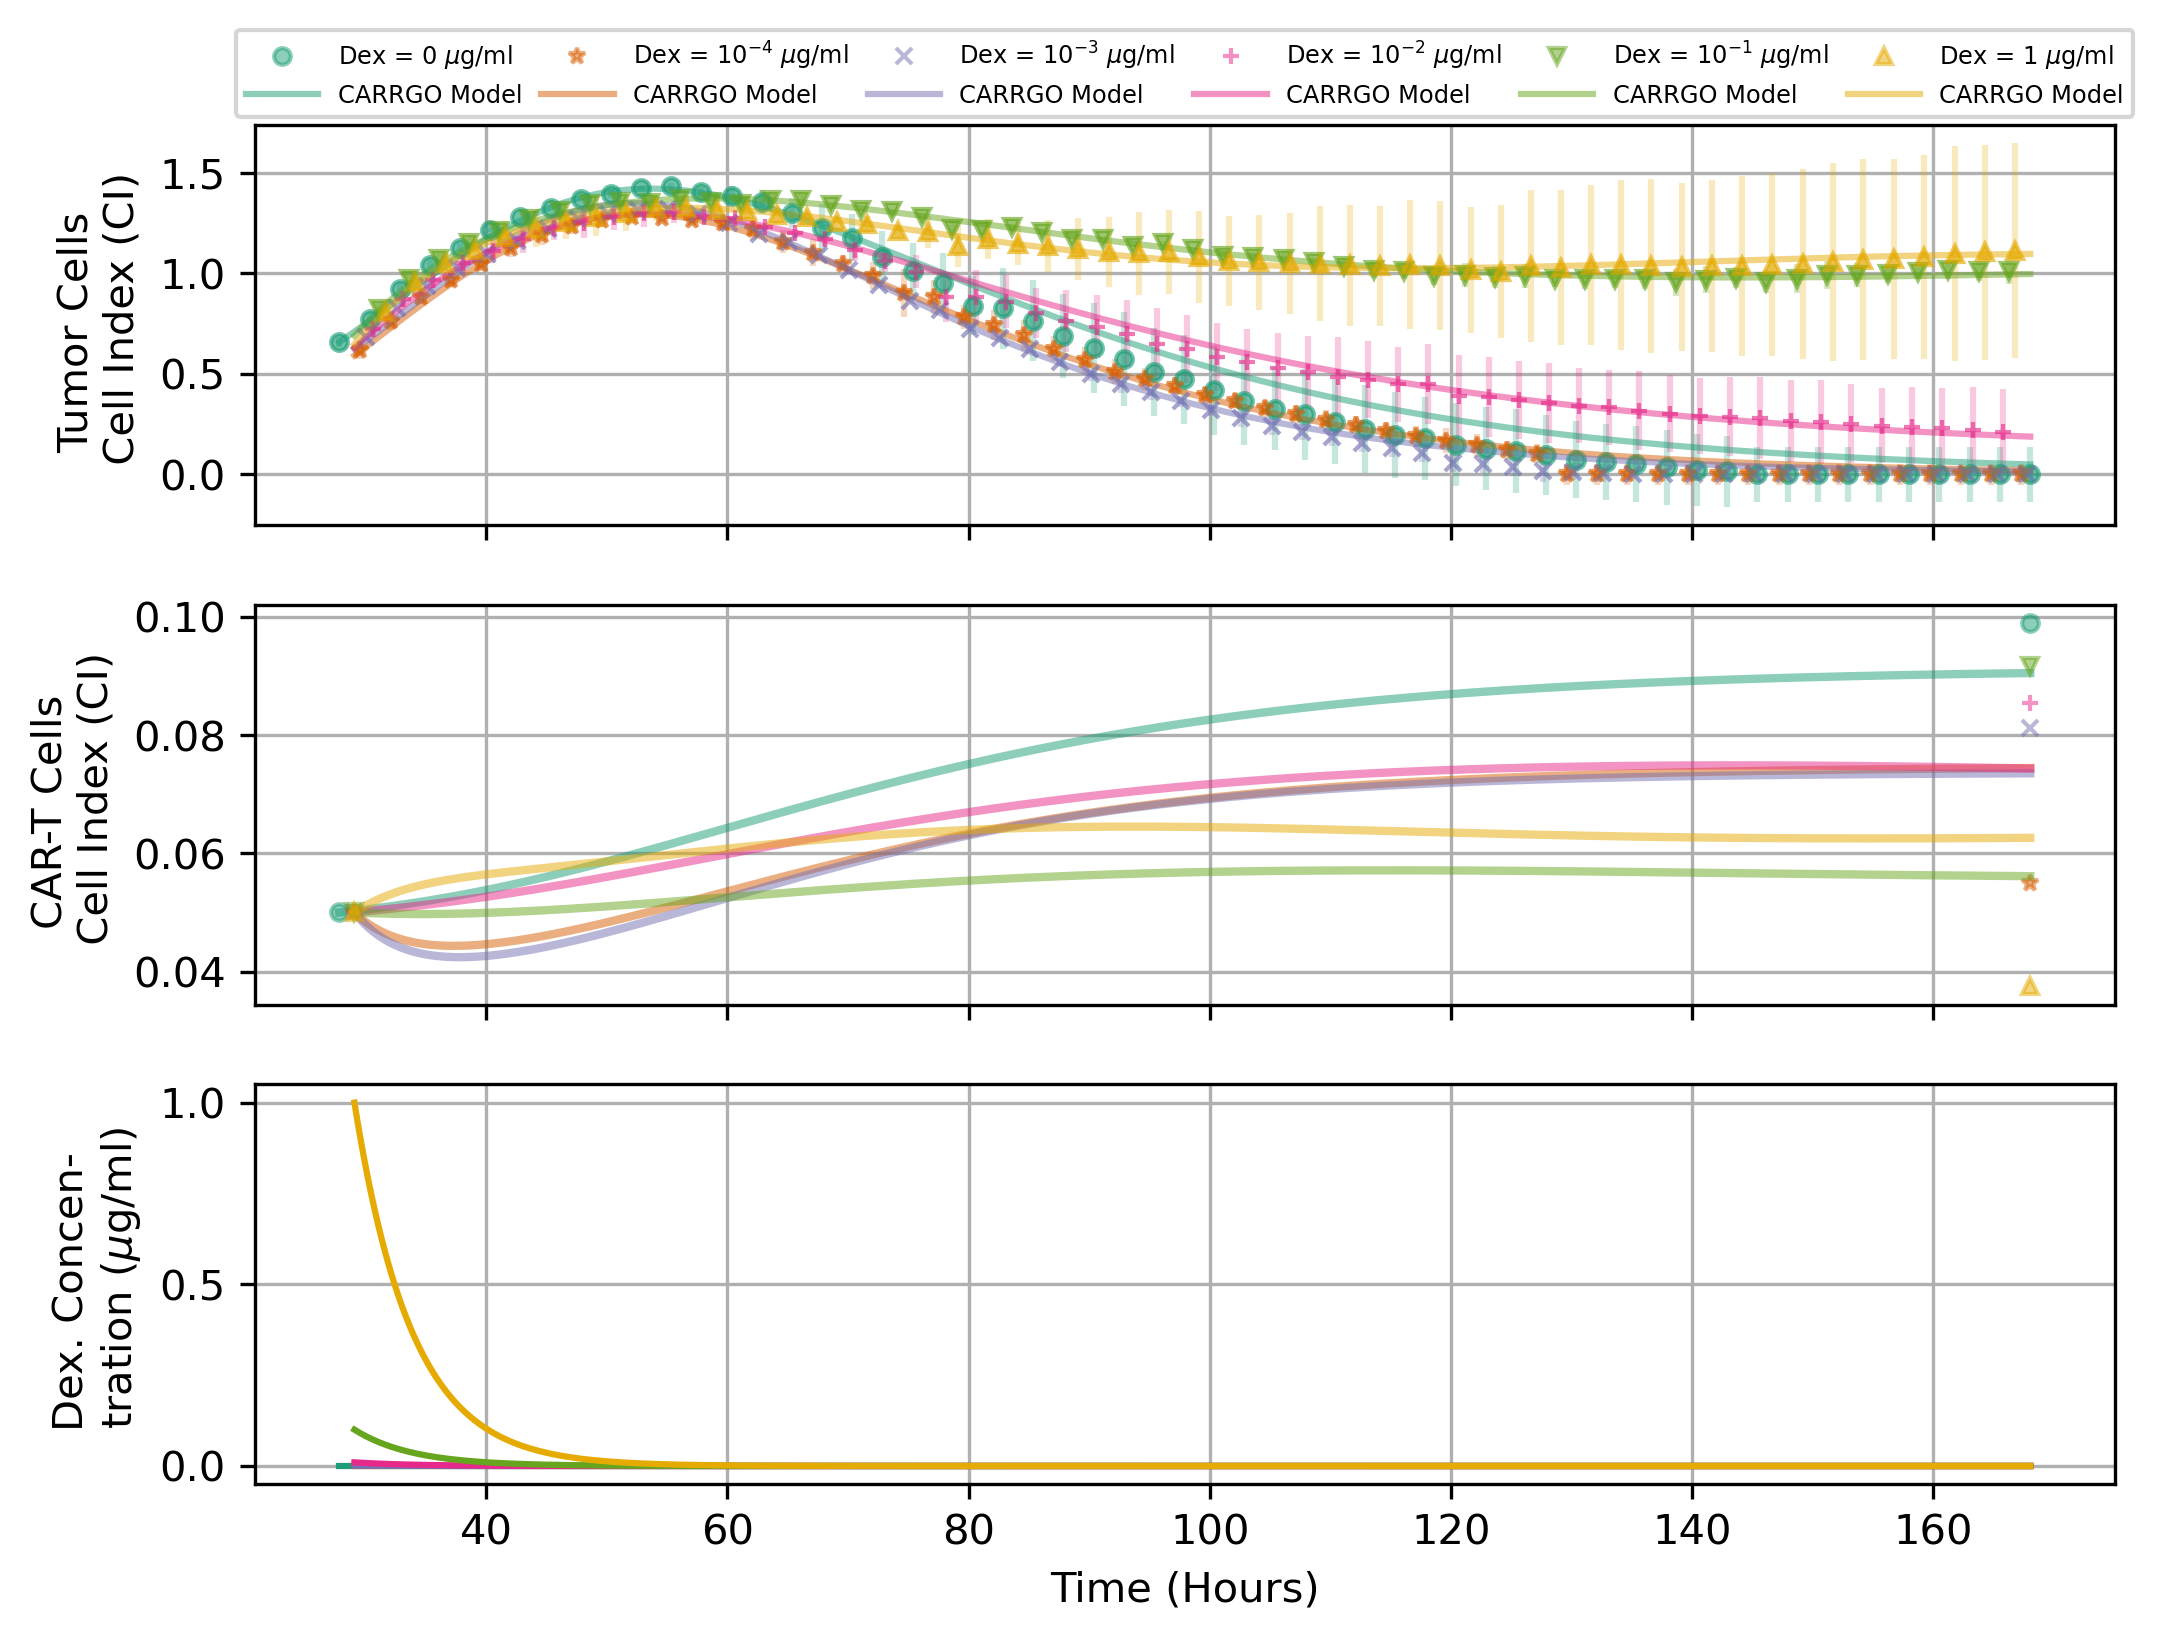

In [10]:
## Plotting

#plt.figure()

## Formatting block for SI notation
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)


plt.figure(num=None, figsize=(8, 6), dpi=300)
for i in range(6,12):
    
    print(i)
    sigma_column_t = 'SD' + re.split('Y',data_column_t[i])[1]
#    data_full = np.array(pbt_data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(pbt_3_4_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_3_4_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 666:
        new_time = np.array(pbt_3_4_data[['Time (Hour)']])[end_t[i]:666,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 666-end_t[i]
        # append zeros to data_fit equal to difference in end_t[i] and 666
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 666
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)



    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    prediction = g_dt(t, x0, model_params)
    
    ax1 = plt.subplot(3,1,1)
#    plt.plot(t, data_fit[:,1], data_char_col[i], t, prediction[:,0], data_fit_char_col[i], 
#             label= 'Dex = '+str(dex_start_t)+'ug/ml')
    plt.errorbar(t[np.arange(2*(i-6),len(t), 10)], data_fit[:,1][np.arange(2*(i-6),len(t), 10)], 
                 data_sigma[:,1][np.arange(2*(i-6),len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None',
                 alpha = 0.25, markersize = 4)
    
    plt.plot(t[np.arange(2*(i-6),len(t), 10)], data_fit[:,1][np.arange(2*(i-6),len(t), 10)],
             marker = data_char_sym[i], color = data_char_col[i], 
             linestyle = 'None', label= 'Dex = {} $\mu$g/ml'.format(fmt(dex_start_t)),
            alpha = 0.5, markersize = 4)
    plt.plot(t, prediction[:,0], linestyle = data_fit_char_sym[i], color = data_char_col[i], 
             label= 'CARRGO Model', alpha = 0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.legend(bbox_to_anchor=(-0.01,1.02,1.02,0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=6,
               fontsize = 'xx-small', markerscale = 1, handlelength = 3)
    ax1.grid(True)

#    plt.legend()

    plt.ylabel('Tumor Cells \n Cell Index (CI)')
#    plt.title('PBT138 high responder with dexamethasone gradient and CAR-T low', y = 1.2)
#    plt.plot(t, prediction[:,0], '-', linewidth=2)
#    plt.plot(t, prediction[:,1], '-', linewidth=2)

    ax2 = plt.subplot(3,1,2, sharex = ax1)
    plt.plot(t, prediction[:,1], linestyle = data_fit_char_sym[i],
             color = data_char_col[i], linewidth=2, alpha = 0.5)
    plt.plot(t[-1], t_cell_fin_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.plot(t[0], t_cell_start_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('CAR-T Cells \n Cell Index (CI)')
    ax2.grid(True)
    

    ax3 = plt.subplot(3,1,3, sharex = ax1)
    plt.plot(t, dex_decay(t, dex_start_t, t[0]), linestyle = data_fit_char_sym[i], 
             color = data_char_col[i], label= 'Dex = '+str(dex_start_t)+'$\mu$g/ml')
    ax3.grid(True)
    plt.xlabel('Time (Hours)')
    plt.ylabel('Dex. Concen- \n tration ($\mu$g/ml)')
    plt.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))


plt.savefig(fname='/Users/abrummer/Desktop/pbt138high_cartlow.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()


0
1
2
3
4
5


<ipython-input-17-bc3509671fd5>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3,1,1)
<ipython-input-17-bc3509671fd5>:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(3,1,2, sharex = ax1)
<ipython-input-17-bc3509671fd5>:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

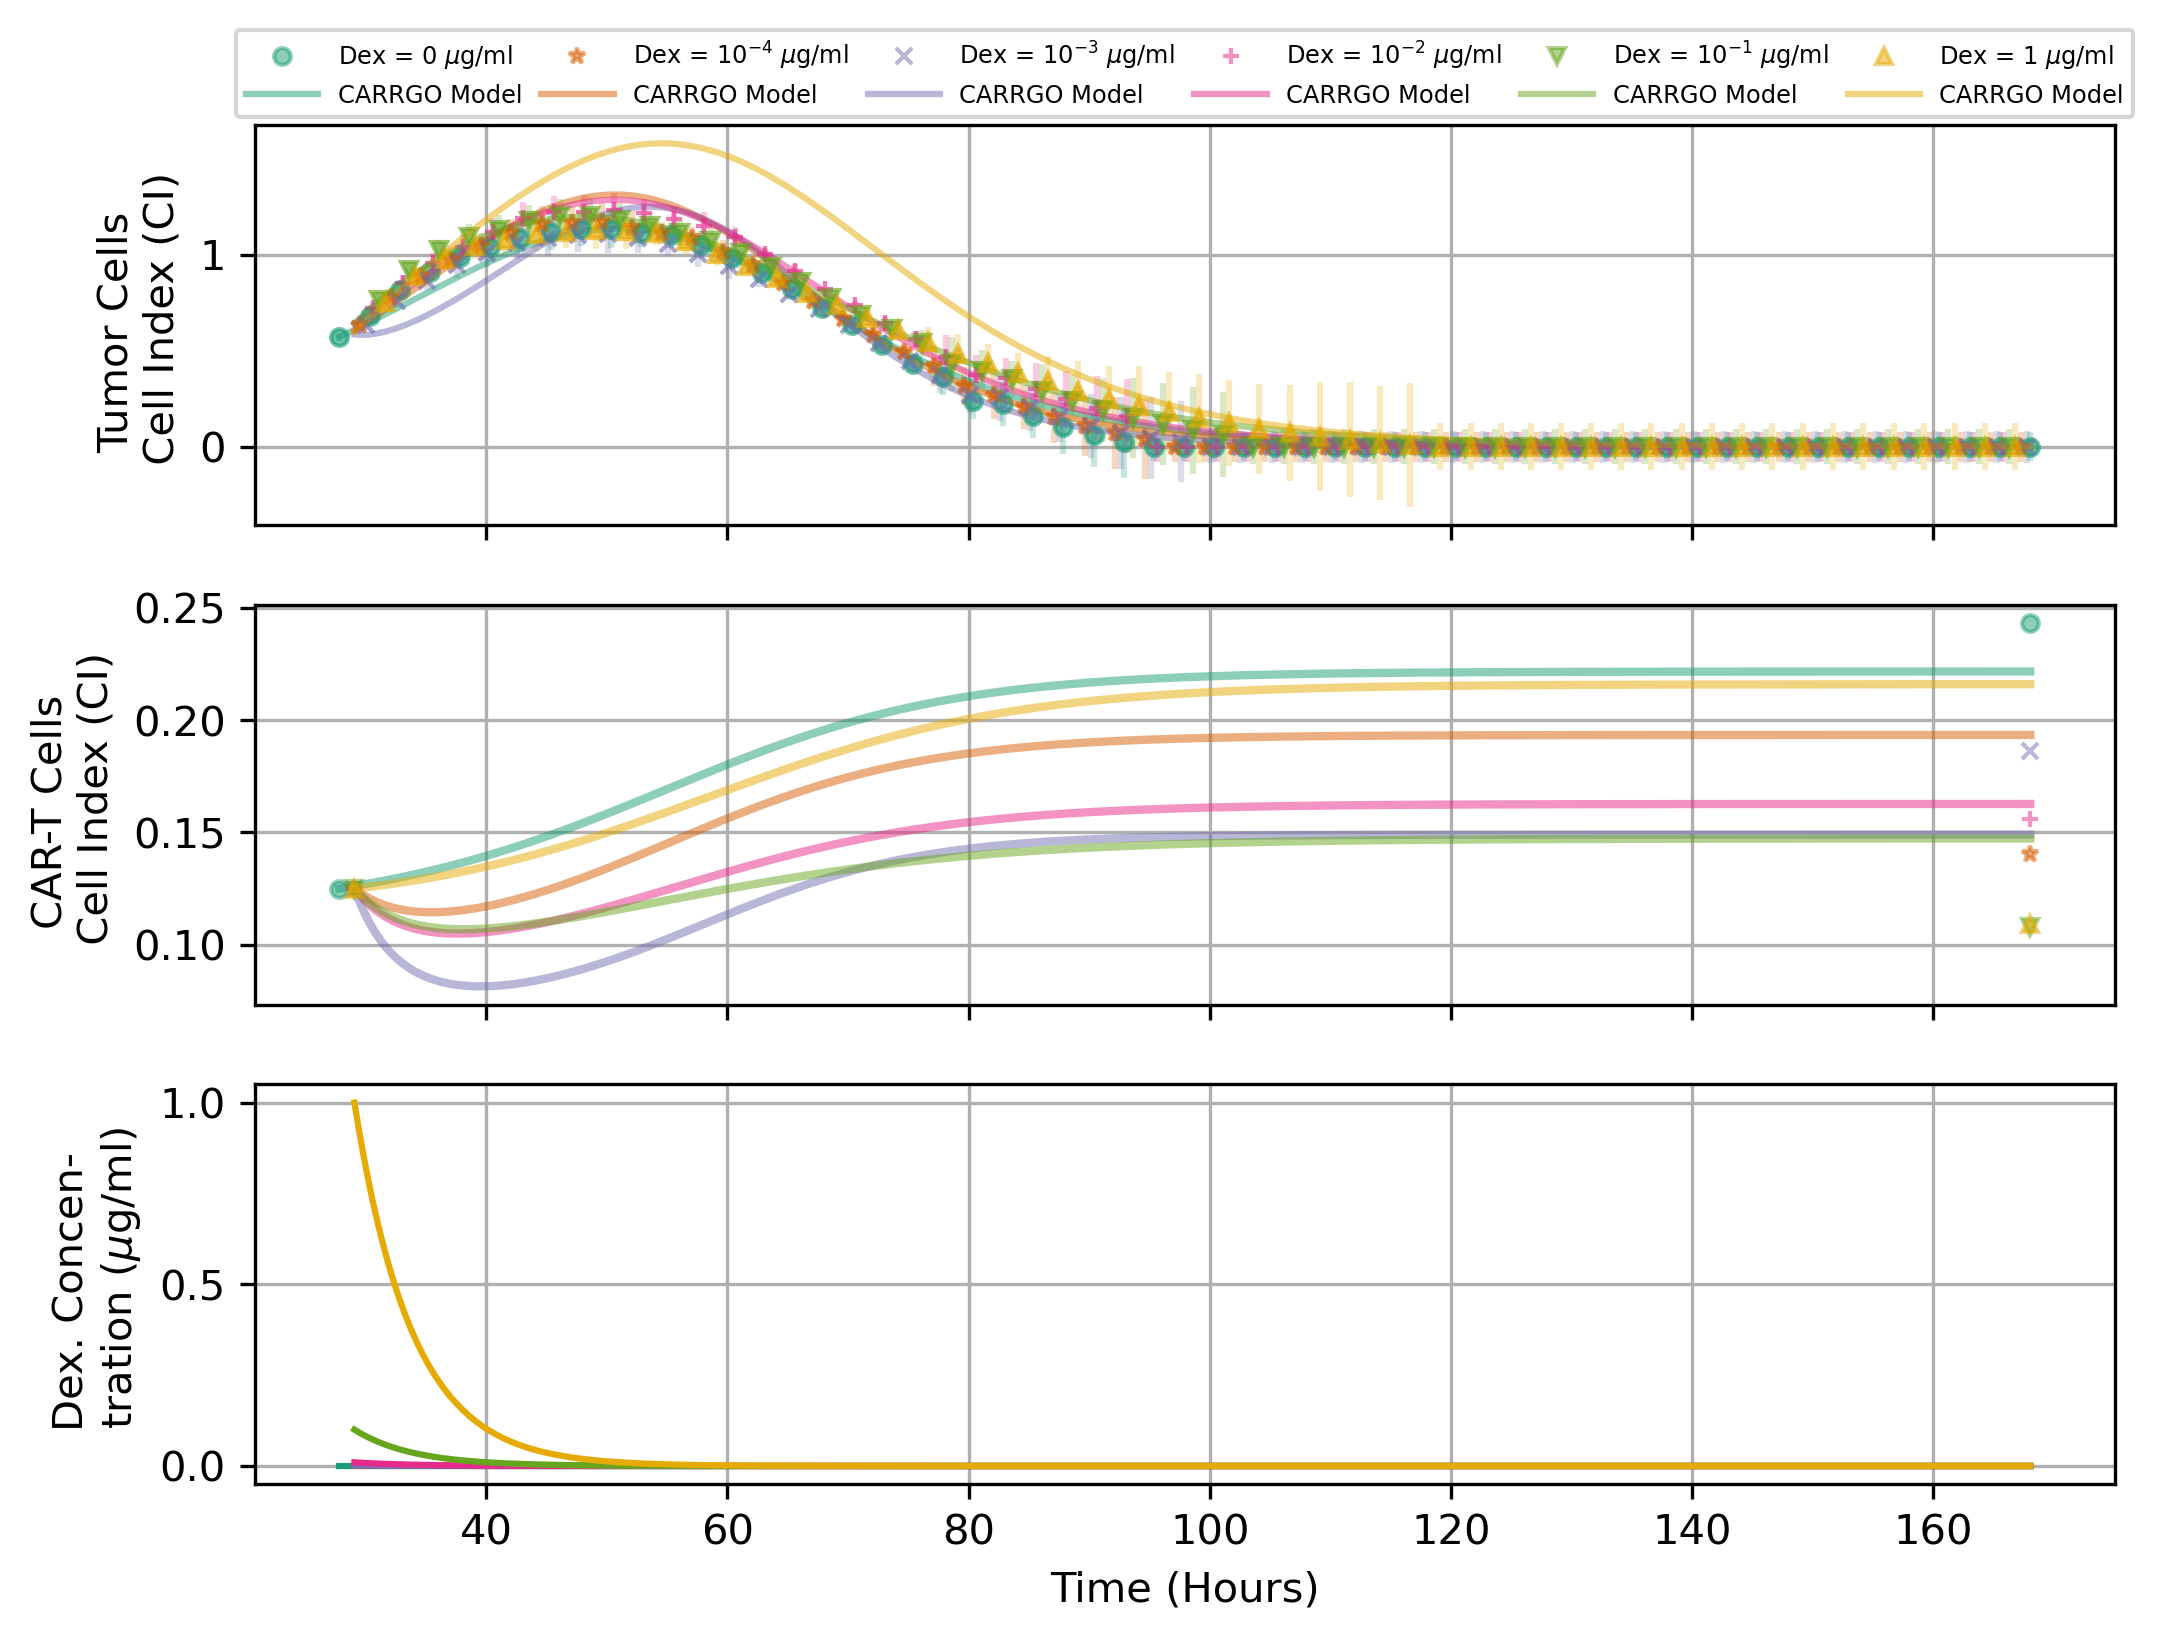

In [17]:
## Plotting

#plt.figure()

plt.figure(num=None, figsize=(8, 6), dpi=300)
for i in range(0,6):
    
    print(i)
#    data_full = np.array(pbt_data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(pbt_3_4_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_3_4_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 666:
        new_time = np.array(pbt_3_4_data[['Time (Hour)']])[end_t[i]:666,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 666-end_t[i]
        # append zeros to data_fit equal to difference in end_t[i] and 666
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 666
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    prediction = g_dt(t, x0, model_params)
    
    ax1 = plt.subplot(3,1,1)
#    plt.plot(t, data_fit[:,1], data_char_col[i], t, prediction[:,0], data_fit_char_col[i], 
#             label= 'Dex = '+str(dex_start_t)+'ug/ml')
    plt.errorbar(t[np.arange(2*i,len(t), 10)], data_fit[:,1][np.arange(2*i,len(t), 10)], 
                 data_sigma[:,1][np.arange(2*i,len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None', alpha = 0.25, markersize = 4)

    plt.plot(t[np.arange(2*i,len(t), 10)], data_fit[:,1][np.arange(2*i,len(t), 10)], 
             marker = data_char_sym[i], color = data_char_col[i], 
             linestyle = 'None', label= 'Dex = {} $\mu$g/ml'.format(fmt(dex_start_t)),
            markersize = 4, alpha = 0.5)
    plt.plot(t, prediction[:,0], linestyle = data_fit_char_sym[i], color = data_char_col[i], 
             label= 'CARRGO Model', alpha = 0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.legend(bbox_to_anchor=(-0.01,1.02,1.02,0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=6,
               fontsize = 'xx-small', markerscale = 1, handlelength = 3)
    ax1.grid(True)

#    plt.legend()

    plt.ylabel('Tumor Cells \n Cell Index (CI)')
#    plt.title('PBT138 high responder with dexamethasone gradient and CAR-T medium', y = 1.2)
#    plt.plot(t, prediction[:,0], '-', linewidth=2)
#    plt.plot(t, prediction[:,1], '-', linewidth=2)

    ax2 = plt.subplot(3,1,2, sharex = ax1)
    plt.plot(t, prediction[:,1], linestyle = data_fit_char_sym[i],
             color = data_char_col[i], linewidth=2, alpha = 0.5)
    plt.plot(t[-1], t_cell_fin_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.plot(t[0], t_cell_start_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('CAR-T Cells \n Cell Index (CI)')
    ax2.grid(True)
    

    ax3 = plt.subplot(3,1,3, sharex = ax1)
    plt.plot(t, dex_decay(t, dex_start_t, t[0]), linestyle = data_fit_char_sym[i], 
             color = data_char_col[i], label= 'Dex = '+str(dex_start_t)+'$\mu$g/ml')
    ax3.grid(True)
    plt.xlabel('Time (Hours)')
    plt.ylabel('Dex. Concen- \n tration ($\mu$g/ml)')
    plt.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))


plt.savefig(fname='/Users/abrummer/Desktop/pbt138high_cartmed.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()


12
13
14
15


<ipython-input-18-0af0edbd62b8>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3,1,1)
<ipython-input-18-0af0edbd62b8>:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(3,1,2, sharex = ax1)
<ipython-input-18-0af0edbd62b8>:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

16
17


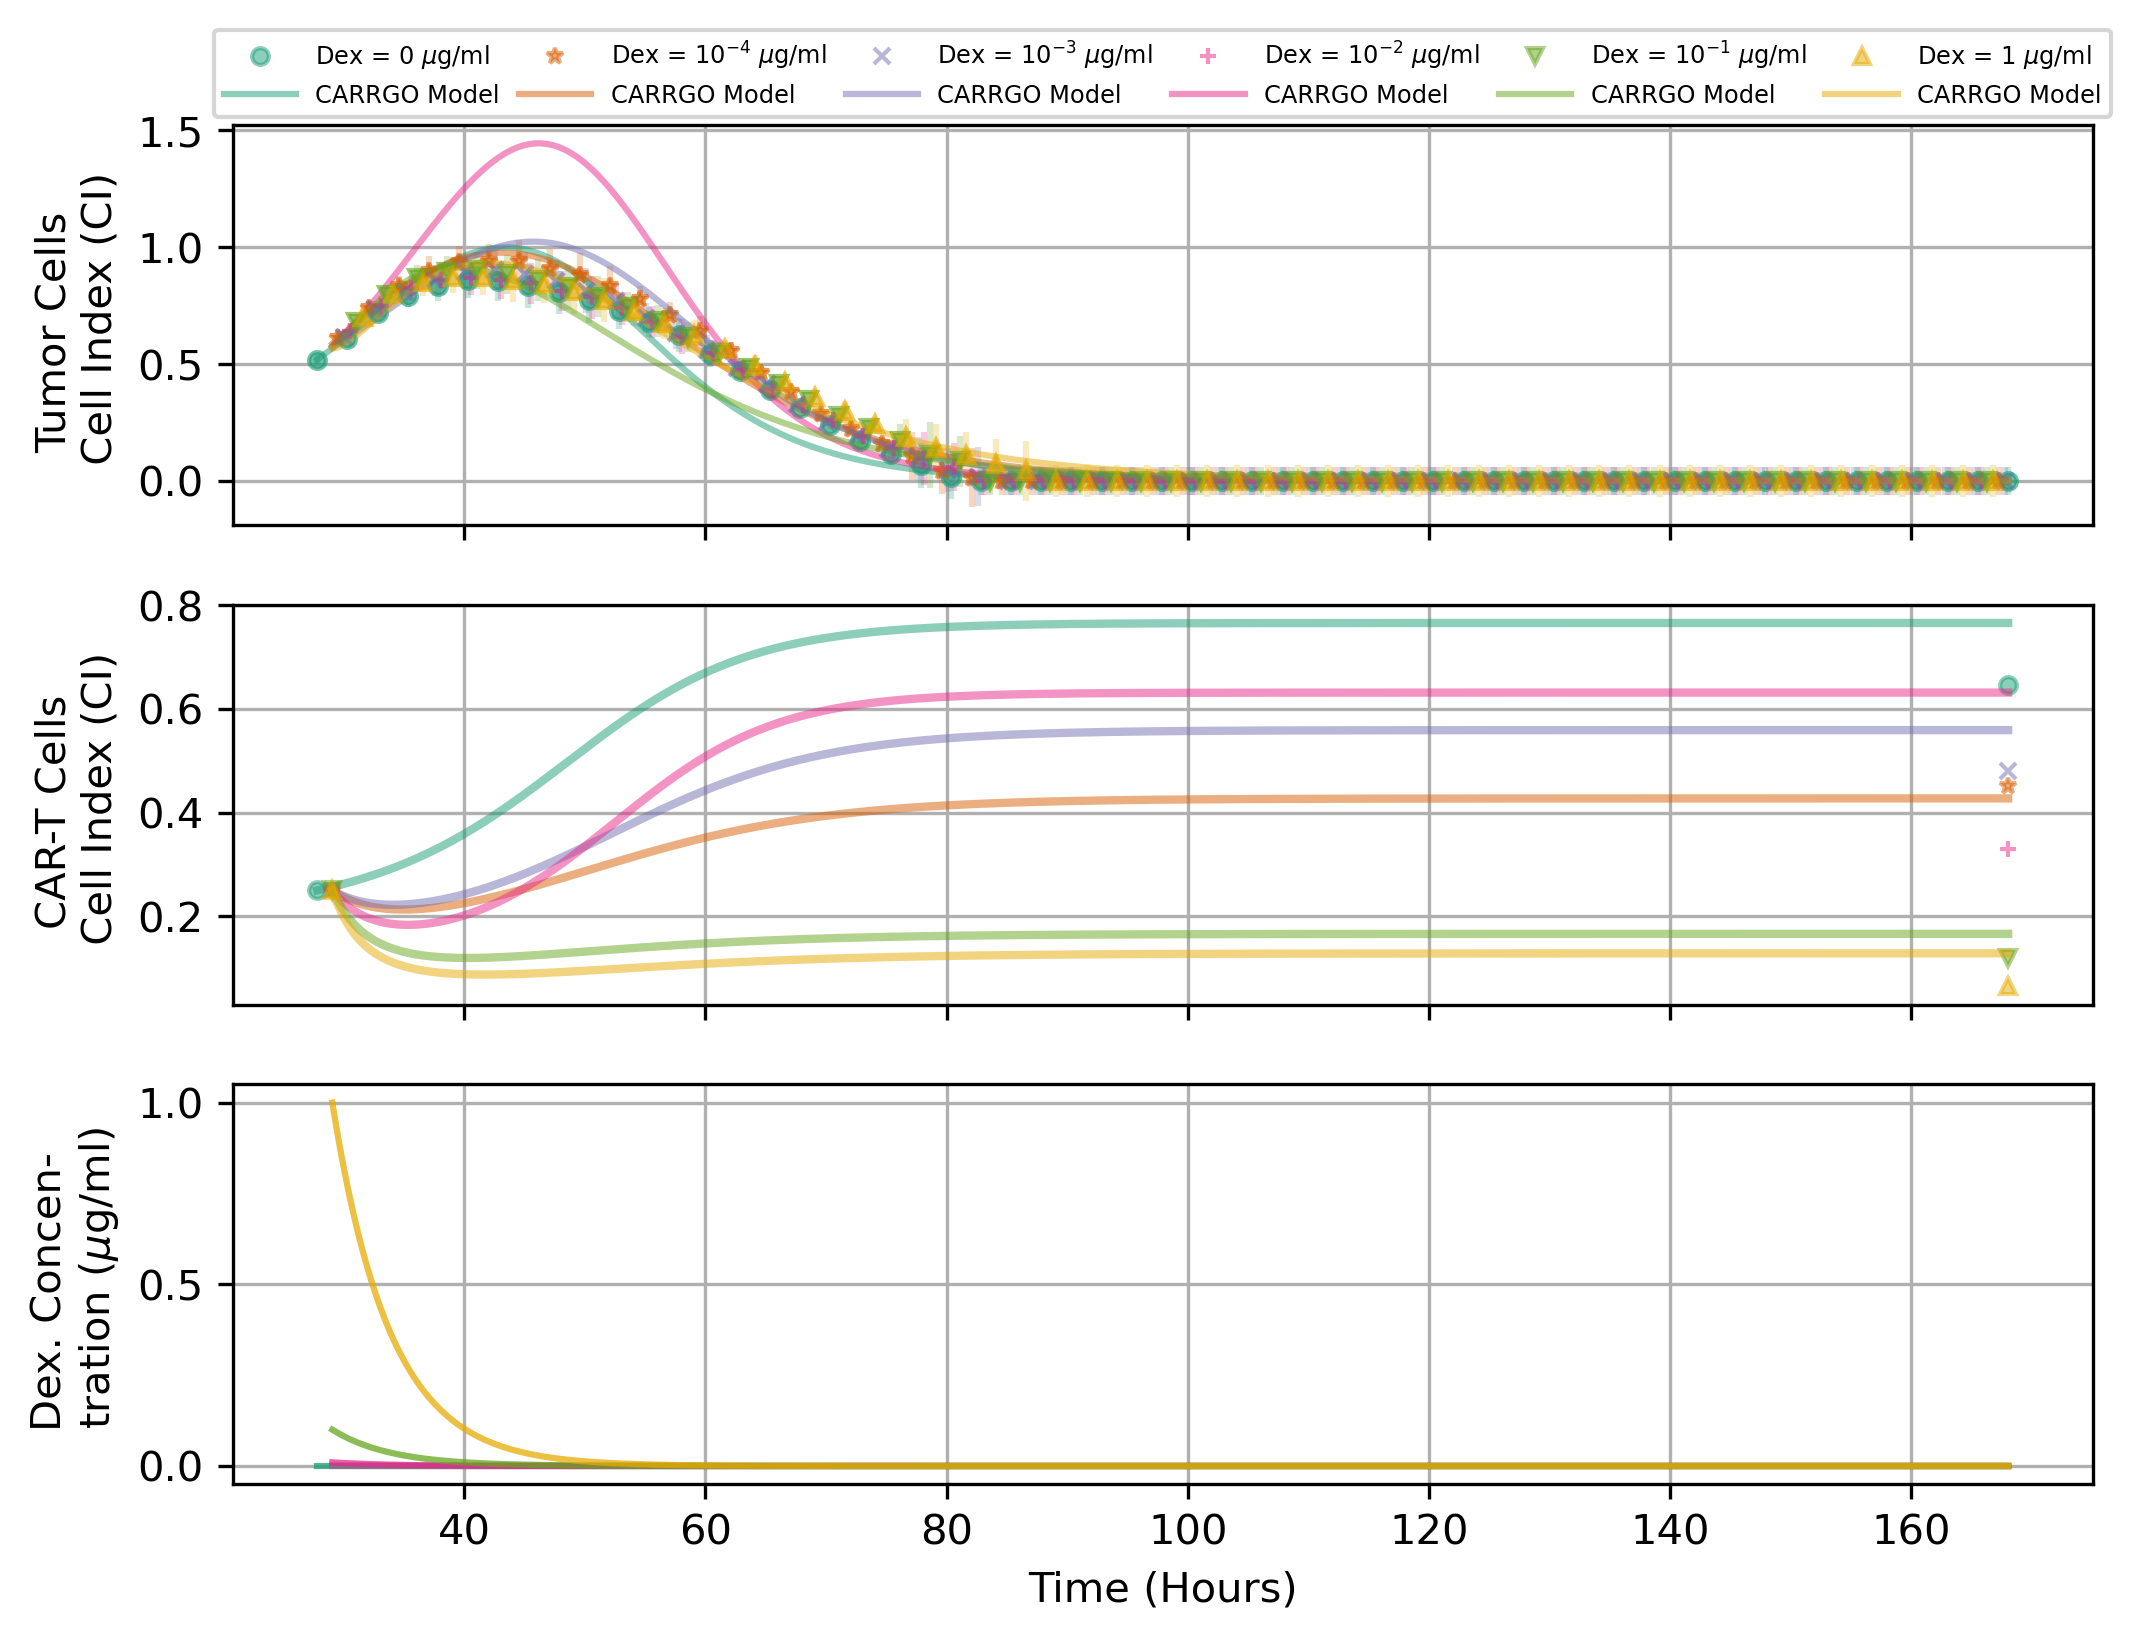

In [18]:
## Plotting

#plt.figure()

plt.figure(num=None, figsize=(8, 6), dpi=300)
for i in range(12,18):
    
    print(i)
#    data_full = np.array(pbt_data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(pbt_3_4_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_3_4_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 666:
        new_time = np.array(pbt_3_4_data[['Time (Hour)']])[end_t[i]:666,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 666-end_t[i]
        # append zeros to data_fit equal to difference in end_t[i] and 666
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 666
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    prediction = g_dt(t, x0, model_params)
    
    ax1 = plt.subplot(3,1,1)
#    plt.plot(t, data_fit[:,1], data_char_col[i], t, prediction[:,0], data_fit_char_col[i], 
#             label= 'Dex = '+str(dex_start_t)+'ug/ml')

    plt.errorbar(t[np.arange(2*(i-12),len(t), 10)], data_fit[:,1][np.arange(2*(i-12),len(t), 10)], 
                 data_sigma[:,1][np.arange(2*(i-12),len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None', alpha = 0.25, markersize = 4)

    plt.plot(t[np.arange(2*(i-12),len(t), 10)], data_fit[:,1][np.arange(2*(i-12),len(t), 10)],
             marker = data_char_sym[i], color = data_char_col[i], linestyle = 'None',
             label= 'Dex = {} $\mu$g/ml'.format(fmt(dex_start_t)), alpha = 0.5, markersize = 4)
    plt.plot(t, prediction[:,0], linestyle = data_fit_char_sym[i], color = data_char_col[i], 
             label= 'CARRGO Model', alpha = 0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.legend(bbox_to_anchor=(-0.01,1.02,1.02,0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=6,
               fontsize = 'xx-small', markerscale = 1, handlelength = 3)
    ax1.grid(True)

#    plt.legend()

    plt.ylabel('Tumor Cells \n Cell Index (CI)')
#    plt.title('PBT138 high responder with dexamethasone gradient and CAR-T high', y = 1.2)
#    plt.plot(t, prediction[:,0], '-', linewidth=2)
#    plt.plot(t, prediction[:,1], '-', linewidth=2)

    ax2 = plt.subplot(3,1,2, sharex = ax1)
    plt.plot(t, prediction[:,1], linestyle = data_fit_char_sym[i], color = data_char_col[i],
             linewidth=2, alpha = 0.5)
    plt.plot(t[-1], t_cell_fin_t, marker = data_char_sym[i], color = data_char_col[i],
            markersize = 4, alpha = 0.5)
    plt.plot(t[0], t_cell_start_t, marker = data_char_sym[i], color = data_char_col[i],
            markersize = 4, alpha = 0.5)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('CAR-T Cells \n Cell Index (CI)')
    ax2.grid(True)
    

    ax3 = plt.subplot(3,1,3, sharex = ax1)
    plt.plot(t, dex_decay(t, dex_start_t, t[0]), linestyle = data_fit_char_sym[i], 
             color = data_char_col[i], label= 'Dex = '+str(dex_start_t)+'g/ml',
            alpha = 0.75)
    ax3.grid(True)
    plt.xlabel('Time (Hours)')
    plt.ylabel('Dex. Concen- \n tration ($\mu$g/ml)')
    plt.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))


plt.savefig(fname='/Users/abrummer/Desktop/pbt138high_carthigh.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()


In [19]:
## Data/fit table accession for PBT030 (PBT 1)

## Practice grabbing one columne of data, predicting, and plotting both.
## Initializing values.

start_t = [100,100,100,100,100,100,
          100,100,100,100,100,100,
          100,100,100,100,100,100]
end_t = [440,400,448,450,410,450,
        652,652,652,652,652,652,
        652,652,652,652,652,652]
data_column_t = ['Y(B1,B2)','Y(B3,B4)','Y(B5,B6)','Y(B7,B8)','Y(B9,B10)','Y(B11,B12)',
                'Y(C1,C2)','Y(C3,C4)','Y(C5,C6)','Y(C7,C8)','Y(C9,C10)','Y(C11,C12)',
                'Y(D1,D2)','Y(D3,D4)','Y(D5,D6)','Y(D7,D8)','Y(D9,D10)','Y(D11,D12)']
# DEFINE THESE USING fit_rows AND data_column_t AND DYNAMIC INDEXING.
#t_cell_start_t = [0,0,0]
#t_cell_fin_t = []
#dex_start_t = [0.00,1.00,0.10,0.01]
fit_rows = [1,9,10,12,12,13,
            2,14,15,16,17,18,
            3,19,20,21,22,23]

#data_char_col = ['mo','c*','gx','r+', 'mv', 'c^',
#                'mo','c*','gx','r+', 'mv', 'c^']
#data_char_col = ['m','c','g','r', 'm', 'c',
#                'm','c','g','r', 'm', 'c']
#data_char_col = ['#ffffcc', '#c7e9b4', '#7fcdbb', '#41b6c4', '#2c7fb8', '#253494',
#                '#ffffcc', '#c7e9b4', '#7fcdbb', '#41b6c4', '#2c7fb8', '#253494']
data_char_col = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02',
                '#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02',
                '#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02']
data_char_sym = ['o', '*', 'x', '+', 'v', '^',
                'o', '*', 'x', '+', 'v', '^',
                'o', '*', 'x', '+', 'v', '^']
#fit_char_col -> data_fit_char_col
#data_fit_char_col = ['k-','k--','k-.','k:', 'k-', 'k--',
#                    'k-','k--','k-.','k:', 'k-', 'k--']
data_fit_char_col = ['k','k','k','k', 'k', 'k',
                    'k','k','k','k', 'k', 'k',
                    'k','k','k','k', 'k', 'k']
data_fit_char_sym = ['-','-','-','-','-','-',
                     '-','-','-','-','-','-',
                     '-','-','-','-','-','-']
#data_fit_char_sym = ['-','--','-.',':', (0, (3, 5, 1, 5)), (0, (5, 5)),
#                    '-','--','-.',':', (0, (3, 5, 1, 5)), (0, (5, 5)),
#                    '-','--','-.',':', (0, (3, 5, 1, 5)), (0, (5, 5))]

tcell_char_col = ['k-','k--','k-.','k:', 'k-', 'k--',
                 'k-','k--','k-.','k:', 'k-', 'k--']
tcell_fit_char_col = ['m-','c--','g-.','r:', 'm-', 'c--',
                     'm-','c--','g-.','r:', 'm-', 'c--']


0
1
2
3
4
5


<ipython-input-20-adae6f79e196>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3,1,1)
<ipython-input-20-adae6f79e196>:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(3,1,2, sharex = ax1)
<ipython-input-20-adae6f79e196>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

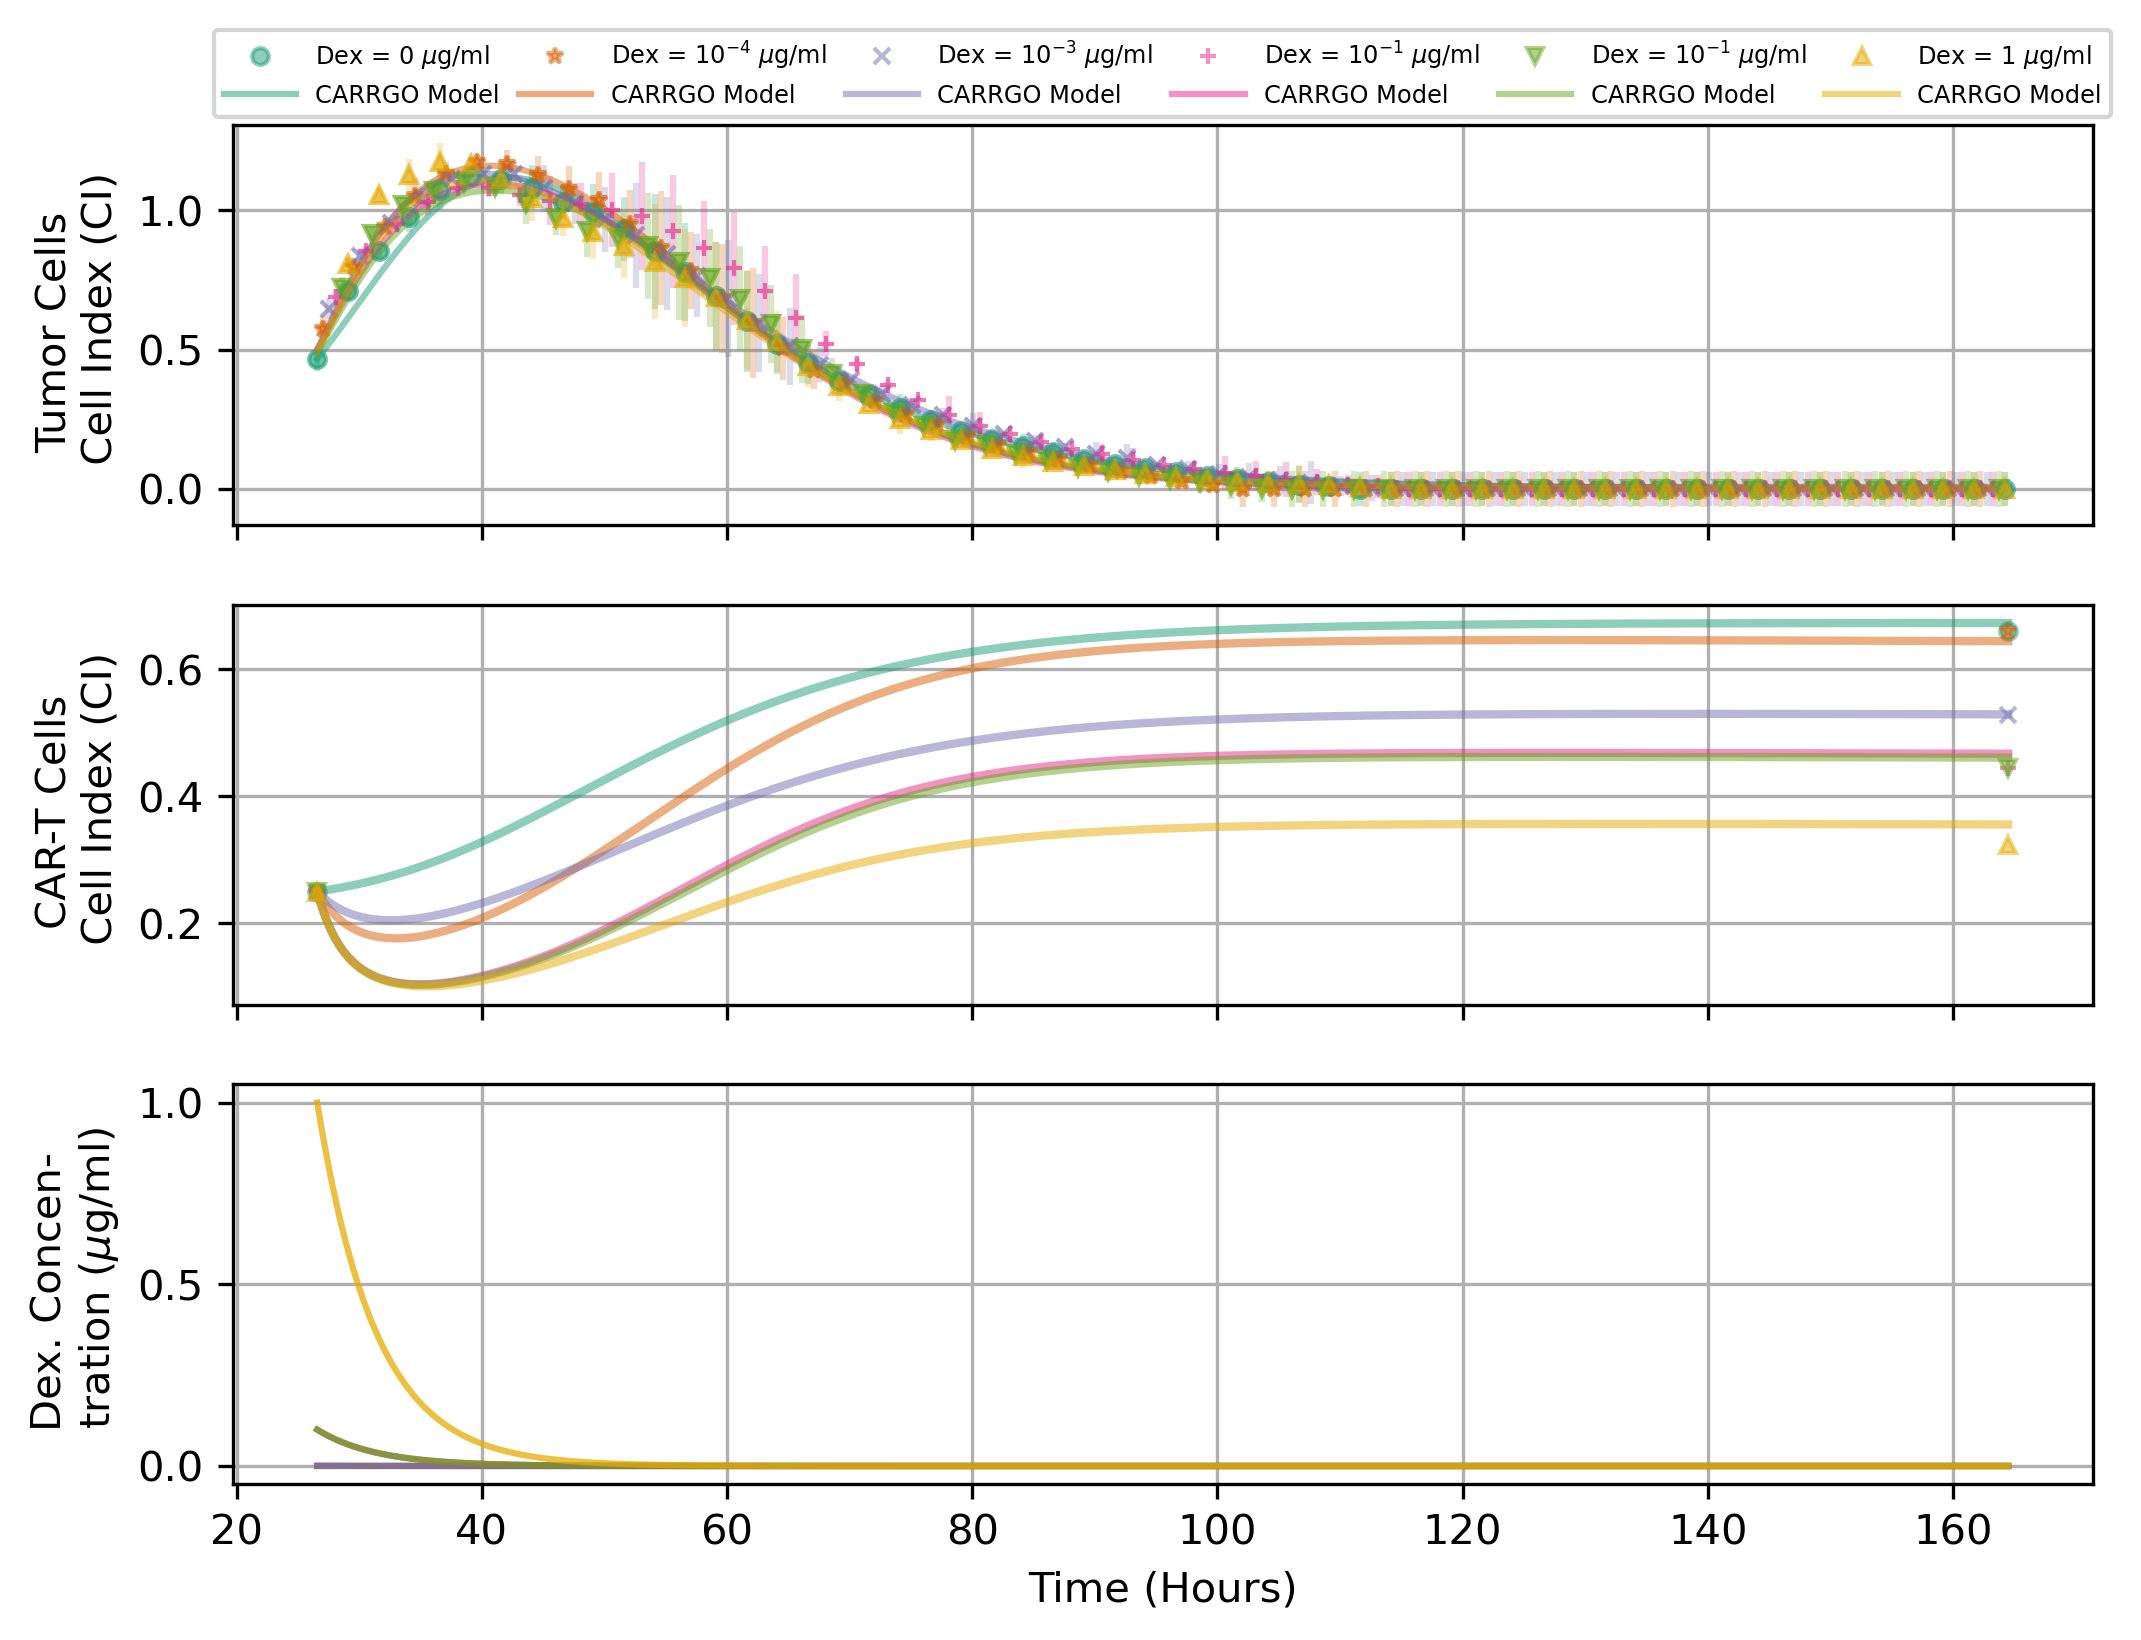

In [20]:
## Data/fit table accession for PBT030 (PBT 1) High CAR-T

#plt.figure()

plt.figure(num=None, figsize=(8, 6), dpi=300)
for i in range(0,6):
    
    print(i)
#    data_full = np.array(pbt_data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(pbt_1_2_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_1_2_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(pbt_1_2_data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to dxata_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    prediction = g_dt(t, x0, model_params)
    
    ax1 = plt.subplot(3,1,1)
#    plt.plot(t, data_fit[:,1], data_char_col[i], t, prediction[:,0], data_fit_char_col[i], 
#             label= 'Dex = '+str(dex_start_t)+'ug/ml')

    plt.errorbar(t[np.arange(2*i,len(t), 10)], data_fit[:,1][np.arange(2*i,len(t), 10)], 
                 data_sigma[:,1][np.arange(2*i,len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None', alpha = 0.25, markersize = 4)

    plt.plot(t[np.arange(2*i,len(t), 10)], data_fit[:,1][np.arange(2*i,len(t), 10)], 
             marker = data_char_sym[i], color = data_char_col[i], 
             linestyle = 'None', label= 'Dex = {} $\mu$g/ml'.format(fmt(dex_start_t)),
            markersize = 4, alpha = 0.5)
    plt.plot(t, prediction[:,0], linestyle = data_fit_char_sym[i], color = data_char_col[i], 
             label= 'CARRGO Model', alpha = 0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.legend(bbox_to_anchor=(-0.01,1.02,1.02,0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=6,
               fontsize = 'xx-small', markerscale = 1, handlelength = 3)
    ax1.grid(True)

#    plt.legend()

    plt.ylabel('Tumor Cells \n Cell Index (CI)')
#    plt.title('PBT030 responder with dexamethasone gradient and CAR-T high', y = 1.2)
#    plt.plot(t, prediction[:,0], '-', linewidth=2)
#    plt.plot(t, prediction[:,1], '-', linewidth=2)

    ax2 = plt.subplot(3,1,2, sharex = ax1)
    plt.plot(t, prediction[:,1], linestyle = data_fit_char_sym[i],
             color = data_char_col[i], linewidth=2, alpha = 0.5)
    plt.plot(t[-1], t_cell_fin_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.plot(t[0], t_cell_start_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('CAR-T Cells \n Cell Index (CI)')
    ax2.grid(True)
    

    ax3 = plt.subplot(3,1,3, sharex = ax1)
    plt.plot(t, dex_decay(t, dex_start_t, t[0]), linestyle = data_fit_char_sym[i], 
             color = data_char_col[i], label= 'Dex = '+str(dex_start_t)+'g/ml',
            alpha = 0.75)
    ax3.grid(True)
    plt.xlabel('Time (Hours)')
    plt.ylabel('Dex. Concen- \n tration ($\mu$g/ml)')
    plt.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))


plt.savefig(fname='/Users/abrummer/Desktop/pbt030_carthigh.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()


6
7
8
9
10
11


<ipython-input-21-66d30d3c6b85>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3,1,1)
<ipython-input-21-66d30d3c6b85>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(3,1,2, sharex = ax1)
<ipython-input-21-66d30d3c6b85>:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

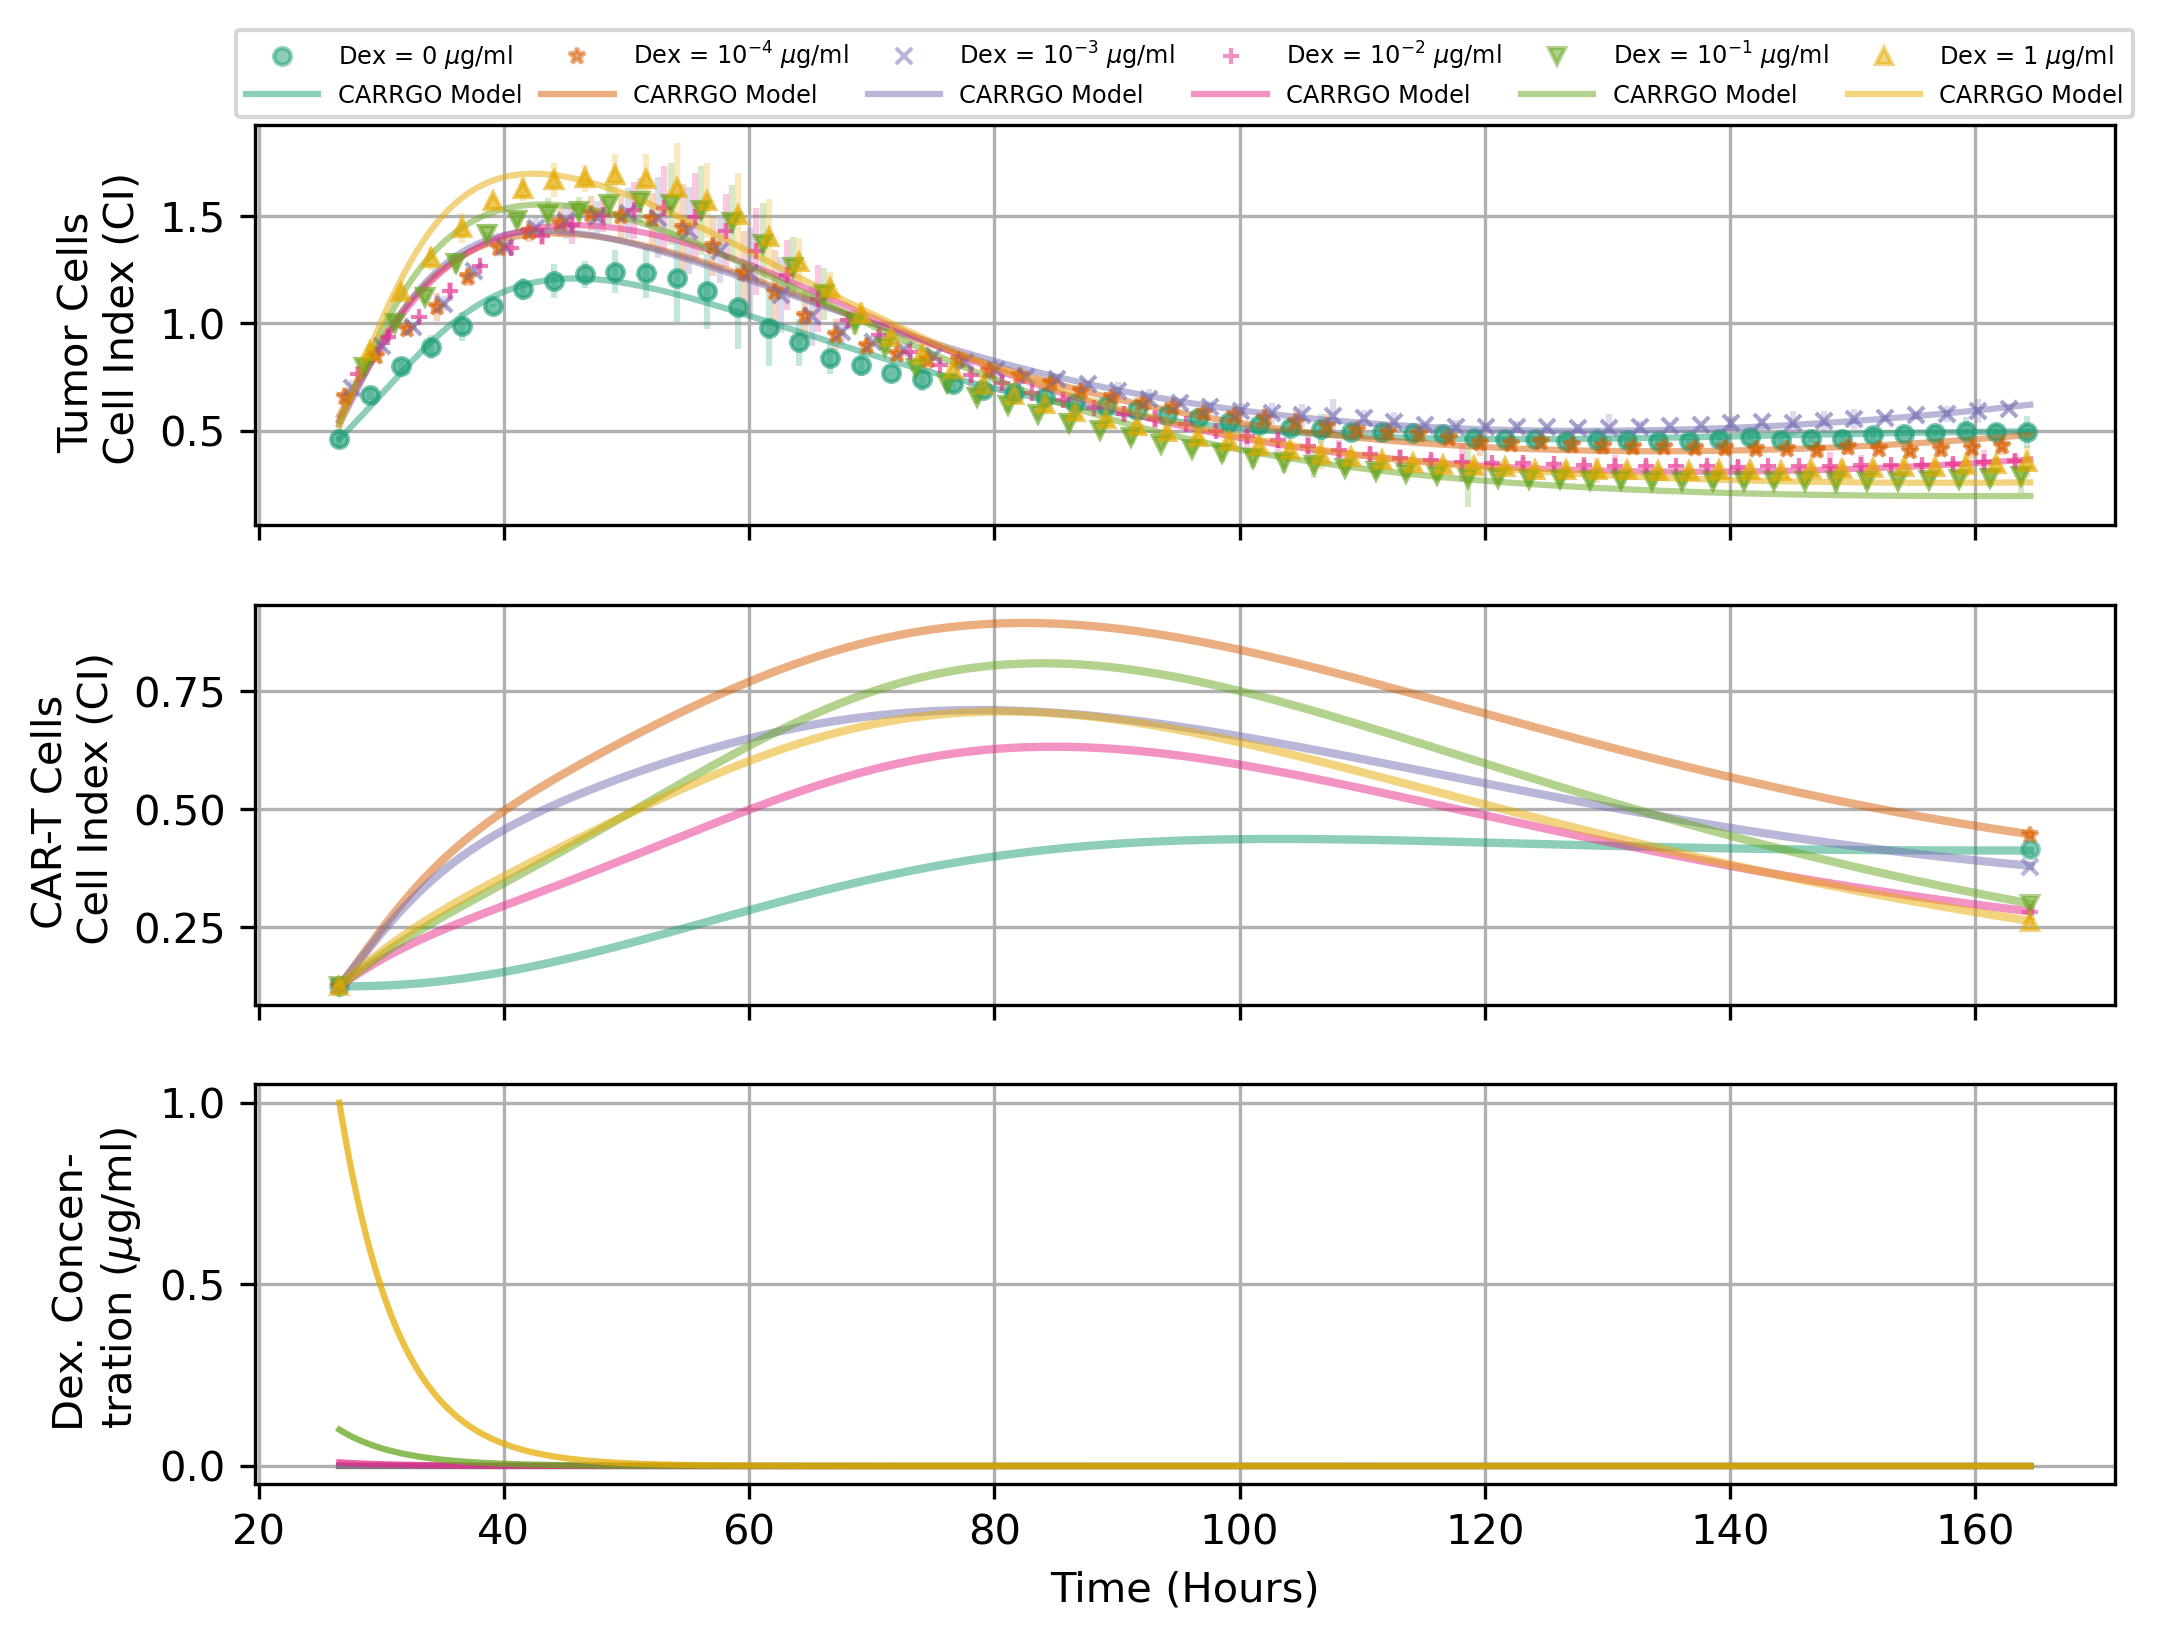

In [21]:
## Data/fit table accession for PBT030 (PBT 1) Medium CAR-T

#plt.figure()

plt.figure(num=None, figsize=(8, 6), dpi=300)
for i in range(6,12):
    
    print(i)
#    data_full = np.array(pbt_data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(pbt_1_2_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_1_2_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(pbt_1_2_data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to dxata_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    prediction = g_dt(t, x0, model_params)
    
    ax1 = plt.subplot(3,1,1)
#    plt.plot(t, data_fit[:,1], data_char_col[i], t, prediction[:,0], data_fit_char_col[i], 
#             label= 'Dex = '+str(dex_start_t)+'ug/ml')
    plt.errorbar(t[np.arange(2*(i-6),len(t), 10)], data_fit[:,1][np.arange(2*(i-6),len(t), 10)], 
                 data_sigma[:,1][np.arange(2*(i-6),len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None', alpha = 0.25, markersize = 4)

    plt.plot(t[np.arange(2*(i-6),len(t), 10)], data_fit[:,1][np.arange(2*(i-6),len(t), 10)],
             marker = data_char_sym[i], color = data_char_col[i], linestyle = 'None',
             label= 'Dex = {} $\mu$g/ml'.format(fmt(dex_start_t)), alpha = 0.5, markersize = 4)
    plt.plot(t, prediction[:,0], linestyle = data_fit_char_sym[i], color = data_char_col[i], 
             label= 'CARRGO Model', alpha = 0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.legend(bbox_to_anchor=(-0.01,1.02,1.02,0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=6,
               fontsize = 'xx-small', markerscale = 1, handlelength = 3)
    ax1.grid(True)

#    plt.legend()

    plt.ylabel('Tumor Cells \n Cell Index (CI)')
#    plt.title('PBT030 responder with dexamethasone gradient and CAR-T med', y = 1.2)
#    plt.plot(t, prediction[:,0], '-', linewidth=2)
#    plt.plot(t, prediction[:,1], '-', linewidth=2)

    ax2 = plt.subplot(3,1,2, sharex = ax1)
    plt.plot(t, prediction[:,1], linestyle = data_fit_char_sym[i],
             color = data_char_col[i], linewidth=2, alpha = 0.5)
    plt.plot(t[-1], t_cell_fin_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.plot(t[0], t_cell_start_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('CAR-T Cells \n Cell Index (CI)')
    ax2.grid(True)
    

    ax3 = plt.subplot(3,1,3, sharex = ax1)
    plt.plot(t, dex_decay(t, dex_start_t, t[0]), linestyle = data_fit_char_sym[i], 
             color = data_char_col[i],label= 'Dex = '+str(dex_start_t)+'g/ml',
            alpha = 0.75)
    ax3.grid(True)
    plt.xlabel('Time (Hours)')
    plt.ylabel('Dex. Concen- \n tration ($\mu$g/ml)')
    plt.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))


plt.savefig(fname='/Users/abrummer/Desktop/pbt030_cartmed.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()


12
13
14
15
16
17


<ipython-input-22-11efacdba7d6>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3,1,1)
<ipython-input-22-11efacdba7d6>:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(3,1,2, sharex = ax1)
<ipython-input-22-11efacdba7d6>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

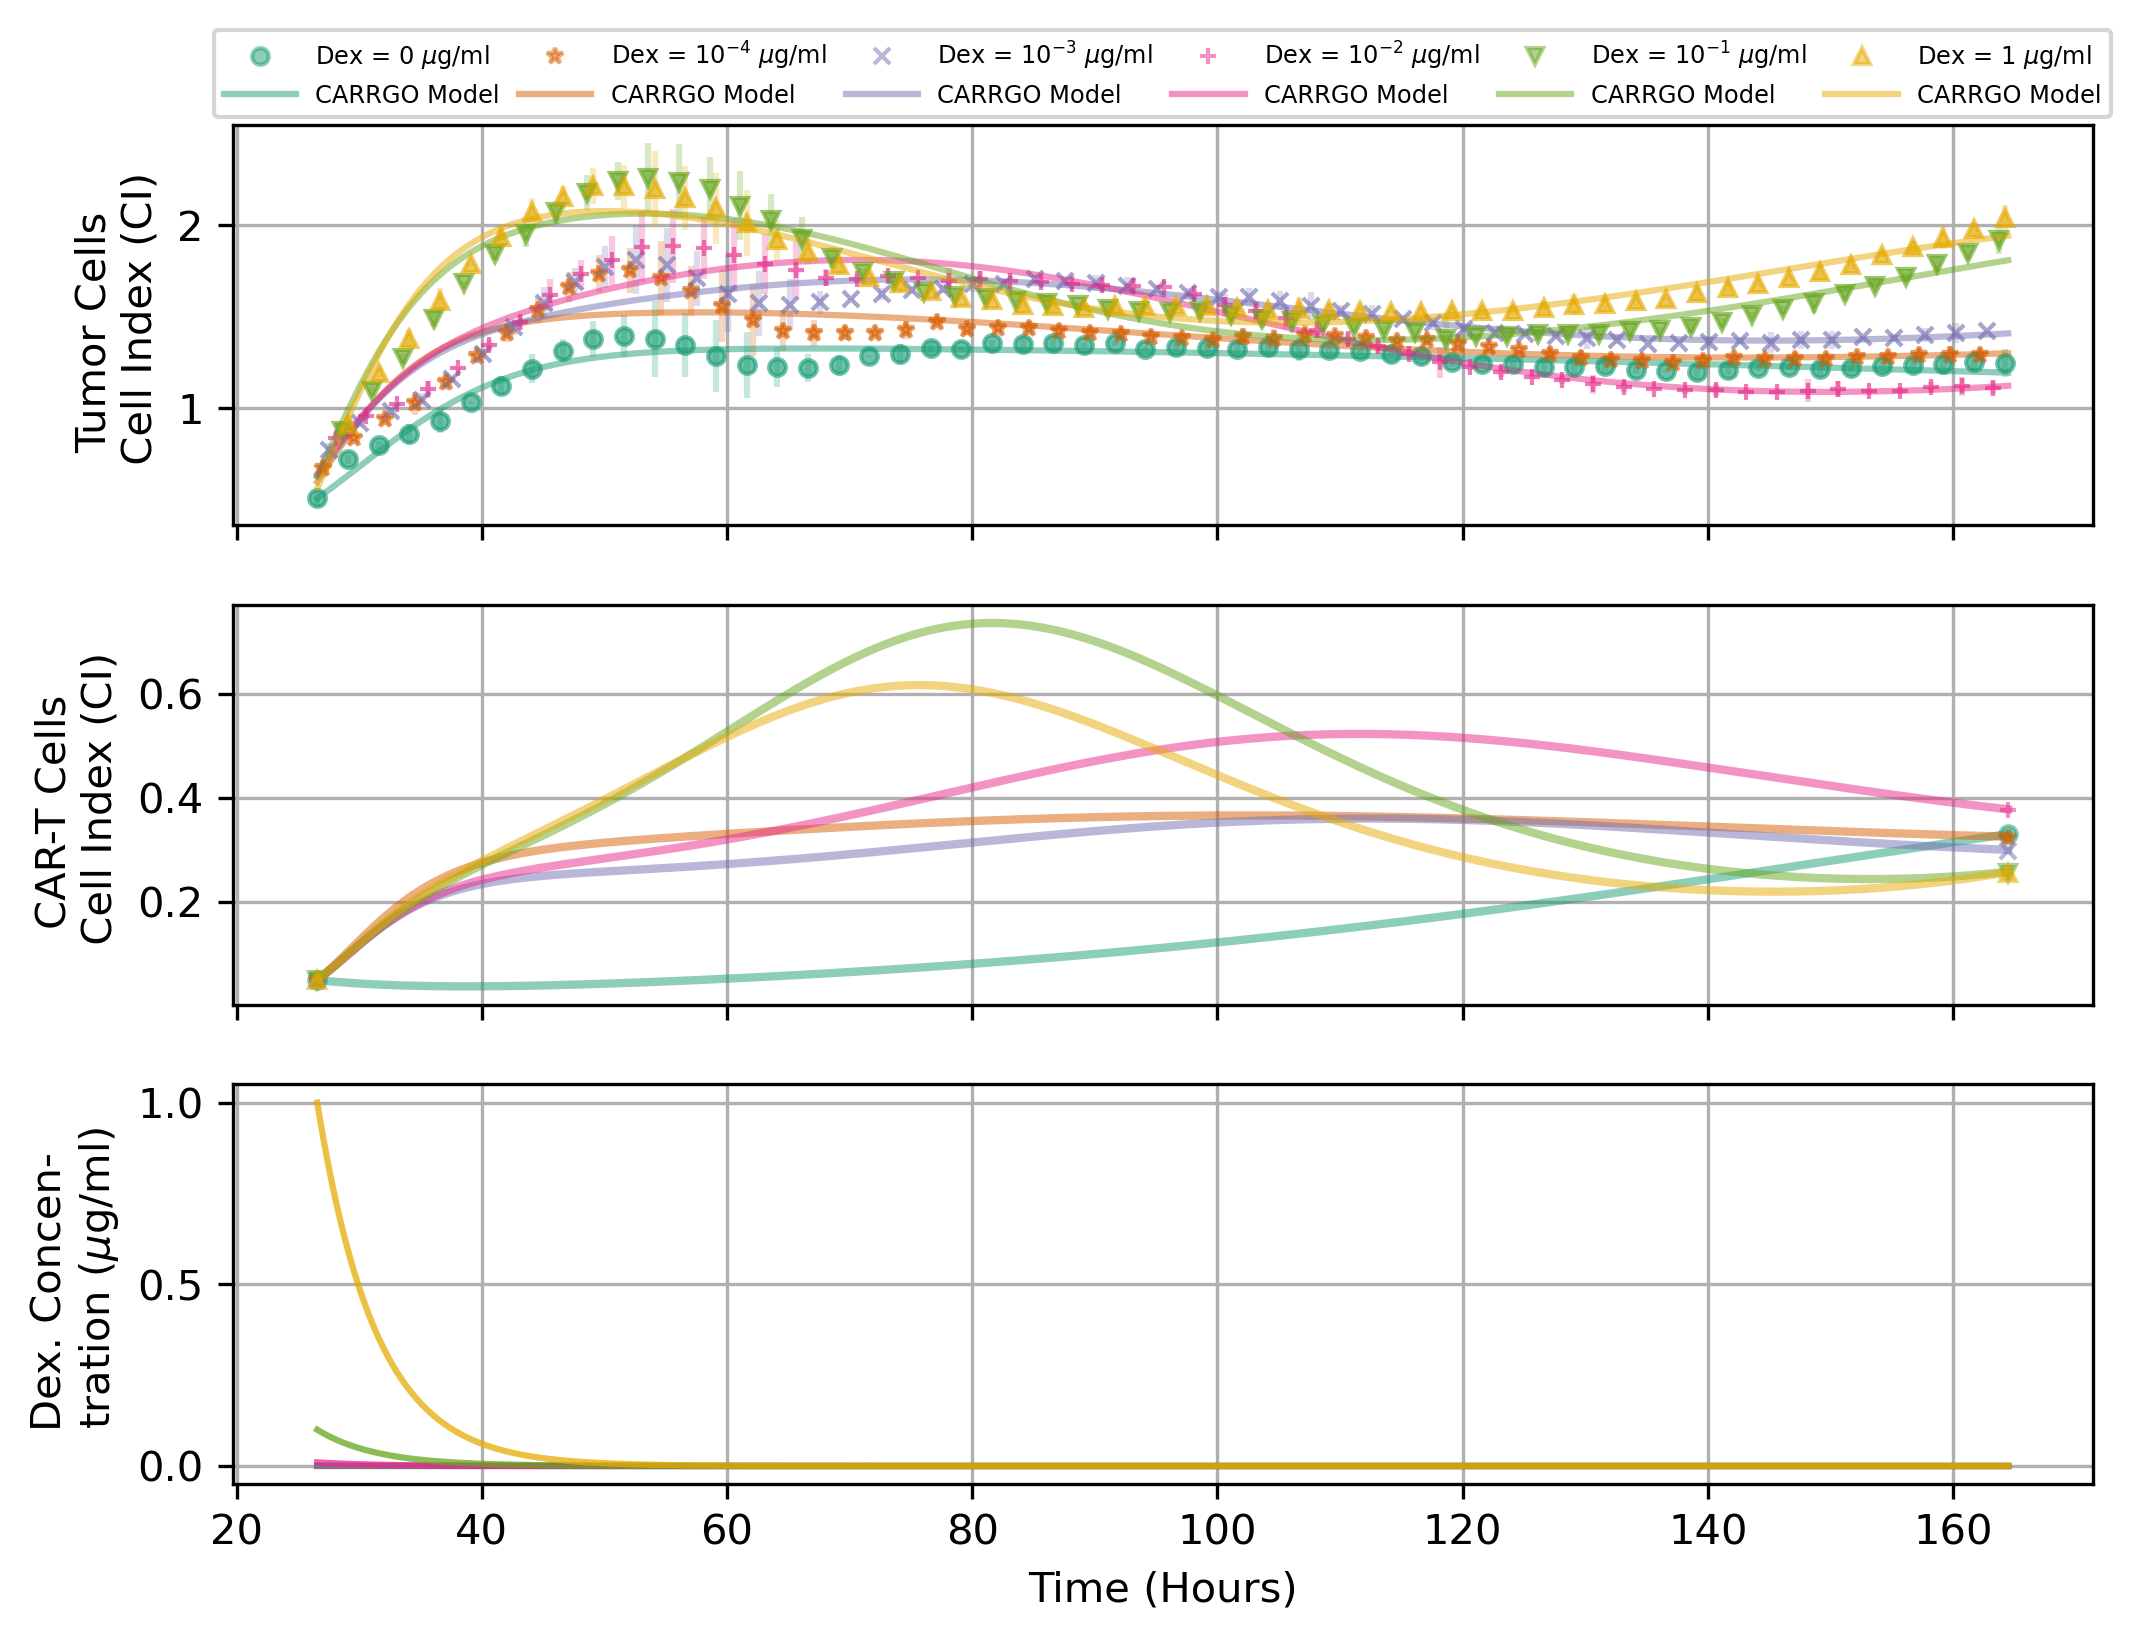

In [22]:
## Data/fit table accession for PBT030 (PBT 1) Low CAR-T

#plt.figure()

plt.figure(num=None, figsize=(8, 6), dpi=300)
for i in range(12,18):
    
    print(i)
#    data_full = np.array(pbt_data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(pbt_1_2_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_1_2_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(pbt_1_2_data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to dxata_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    prediction = g_dt(t, x0, model_params)
    
    ax1 = plt.subplot(3,1,1)
#    plt.plot(t, data_fit[:,1], data_char_col[i], t, prediction[:,0], data_fit_char_col[i], 
#             label= 'Dex = '+str(dex_start_t)+'ug/ml')

    plt.errorbar(t[np.arange(2*(i-12),len(t), 10)], data_fit[:,1][np.arange(2*(i-12),len(t), 10)], 
                 data_sigma[:,1][np.arange(2*(i-12),len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None', alpha = 0.25, markersize = 4)

    plt.plot(t[np.arange(2*(i-12),len(t), 10)], data_fit[:,1][np.arange(2*(i-12),len(t), 10)], 
             marker = data_char_sym[i], color = data_char_col[i], 
             linestyle = 'None',label= 'Dex = {} $\mu$g/ml'.format(fmt(dex_start_t)),
            alpha = 0.5, markersize = 4)
    plt.plot(t, prediction[:,0], linestyle = data_fit_char_sym[i], color = data_char_col[i], 
             label= 'CARRGO Model', alpha = 0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.legend(bbox_to_anchor=(-0.01,1.02,1.02,0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=6,
               fontsize = 'xx-small', markerscale = 1, handlelength = 3)
    ax1.grid(True)

#    plt.legend()

    plt.ylabel('Tumor Cells \n Cell Index (CI)')
#    plt.title('PBT030 responder with dexamethasone gradient and CAR-T low', y = 1.2)
#    plt.plot(t, prediction[:,0], '-', linewidth=2)
#    plt.plot(t, prediction[:,1], '-', linewidth=2)

    ax2 = plt.subplot(3,1,2, sharex = ax1)
    plt.plot(t, prediction[:,1], linestyle = data_fit_char_sym[i],
             color = data_char_col[i], linewidth=2, alpha = 0.5)
    plt.plot(t[-1], t_cell_fin_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.plot(t[0], t_cell_start_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('CAR-T Cells \n Cell Index (CI)')
    ax2.grid(True)
    

    ax3 = plt.subplot(3,1,3, sharex = ax1)
    plt.plot(t, dex_decay(t, dex_start_t, t[0]), linestyle = data_fit_char_sym[i], 
             color = data_char_col[i], label= 'Dex = '+str(dex_start_t)+'g/ml',
            alpha = 0.75)
    ax3.grid(True)
    plt.xlabel('Time (Hours)')
    plt.ylabel('Dex. Concen- \n tration ($\mu$g/ml)')
    plt.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))


plt.savefig(fname='/Users/abrummer/Desktop/pbt030_carlow.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()


In [23]:
## Data/fit table accession for PBT128+ (PBT 2)

## Practice grabbing one columne of data, predicting, and plotting both.
## Initializing values.

start_t = [125,120,120,120,120,120,
          125,120,120,120,120,120,
          125,120,120,120,120,120]
end_t = [345,370,380,652,652,652,
        652,652,652,652,652,652,
        652,652,652,652,652,652]
data_column_t = ['Y(G1,G2)','Y(G3,G4)','Y(G5,G6)','Y(G7,G8)','Y(G9,G10)','Y(G11,G12)',
                'Y(F1,F2)','Y(F3,F4)','Y(F5,F6)','Y(F7,F8)','Y(F9,F10)','Y(F11,F12)',
                'Y(E1,E2)','Y(E3,E4)','Y(E5,E6)','Y(E7,E8)','Y(E9,E10)','Y(E11,E12)']
# DEFINE THESE USING fit_rows AND data_column_t AND DYNAMIC INDEXING.
#t_cell_start_t = [0,0,0]
#t_cell_fin_t = []
#dex_start_t = [0.00,1.00,0.10,0.01]
fit_rows = [25,33,34,35,36,37,
            26,38,39,40,41,42,
            27,43,44,45,46,47]

#data_char_col = ['mo','c*','gx','r+', 'mv', 'c^',
#                'mo','c*','gx','r+', 'mv', 'c^']
#data_char_col = ['m','c','g','r', 'm', 'c',
#                'm','c','g','r', 'm', 'c']
#data_char_col = ['#ffffcc', '#c7e9b4', '#7fcdbb', '#41b6c4', '#2c7fb8', '#253494',
#                '#ffffcc', '#c7e9b4', '#7fcdbb', '#41b6c4', '#2c7fb8', '#253494']
data_char_col = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02',
                '#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02',
                '#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02']
data_char_sym = ['o', '*', 'x', '+', 'v', '^',
                'o', '*', 'x', '+', 'v', '^',
                'o', '*', 'x', '+', 'v', '^']
#fit_char_col -> data_fit_char_col
#data_fit_char_col = ['k-','k--','k-.','k:', 'k-', 'k--',
#                    'k-','k--','k-.','k:', 'k-', 'k--']
data_fit_char_col = ['k','k','k','k', 'k', 'k',
                    'k','k','k','k', 'k', 'k',
                    'k','k','k','k', 'k', 'k']
data_fit_char_sym = ['-','-','-','-','-','-',
                     '-','-','-','-','-','-',
                     '-','-','-','-','-','-']
#data_fit_char_sym = ['-','--','-.',':', (0, (3, 5, 1, 5)), (0, (5, 5)),
#                    '-','--','-.',':', (0, (3, 5, 1, 5)), (0, (5, 5)),
#                    '-','--','-.',':', (0, (3, 5, 1, 5)), (0, (5, 5))]

tcell_char_col = ['k-','k--','k-.','k:', 'k-', 'k--',
                 'k-','k--','k-.','k:', 'k-', 'k--']
tcell_fit_char_col = ['m-','c--','g-.','r:', 'm-', 'c--',
                     'm-','c--','g-.','r:', 'm-', 'c--']


In [24]:
## Data/fit table accession for PBT030 (PBT 1) High CAR-T

#plt.figure()


## Formatting block for SI notation
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)

plt.figure(num=None, figsize=(8, 6), dpi=300)
for i in range(0,6):
    
    print(i)
#    data_full = np.array(pbt_data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(pbt_1_2_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_1_2_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(pbt_1_2_data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to dxata_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    prediction = g_dt(t, x0, model_params)
    
    ax1 = plt.subplot(3,1,1)
#    plt.plot(t, data_fit[:,1], data_char_col[i], t, prediction[:,0], data_fit_char_col[i], 
#             label= 'Dex = '+str(dex_start_t)+'ug/ml')

    plt.errorbar(t[np.arange(2*i,len(t), 10)], data_fit[:,1][np.arange(2*i,len(t), 10)], 
                 data_sigma[:,1][np.arange(2*i,len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None', alpha = 0.25, markersize = 4)
    
    plt.plot(t[np.arange(2*i,len(t), 10)], data_fit[:,1][np.arange(2*i,len(t), 10)], 
             marker = data_char_sym[i], color = data_char_col[i], 
             linestyle = 'None', label= 'Dex = {} $\mu$g/ml'.format(fmt(dex_start_t)),
            markersize = 4, alpha = 0.5)
    plt.plot(t, prediction[:,0], linestyle = data_fit_char_sym[i], color = data_char_col[i], 
             label= 'CARRGO Model', alpha = 0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.legend(bbox_to_anchor=(-0.01,1.02,1.02,0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=6,
               fontsize = 'xx-small', markerscale = 1, handlelength = 3)
    ax1.grid(True)

#    plt.legend()

    plt.ylabel('Tumor Cells \n Cell Index (CI)')
#    plt.title('PBT128+ responder with dexamethasone gradient and CAR-T high', y = 1.2)
#    plt.plot(t, prediction[:,0], '-', linewidth=2)
#    plt.plot(t, prediction[:,1], '-', linewidth=2)

    ax2 = plt.subplot(3,1,2, sharex = ax1)
    plt.plot(t, prediction[:,1], linestyle = data_fit_char_sym[i],
             color = data_char_col[i], linewidth=2, alpha = 0.5)
    plt.plot(t[-1], t_cell_fin_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.plot(t[0], t_cell_start_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('CAR-T Cells \n Cell Index (CI)')
    ax2.grid(True)
    

    ax3 = plt.subplot(3,1,3, sharex = ax1)
    plt.plot(t, dex_decay(t, dex_start_t, t[0]), linestyle = data_fit_char_sym[i], 
             color = data_char_col[i],label= 'Dex = '+str(dex_start_t)+'g/ml',
            alpha = 0.75)
    ax3.grid(True)
    plt.xlabel('Time (Hours)')
    plt.ylabel('Dex. Concen- \n tration ($\mu$g/ml)')
#    plt.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))


plt.savefig(fname='/Users/abrummer/Desktop/pbt128+_carthigh.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()


0
1
2
3
4
5


<ipython-input-24-52783703f6c9>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3,1,1)
<ipython-input-24-52783703f6c9>:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(3,1,2, sharex = ax1)
<ipython-input-24-52783703f6c9>:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

6
7
8
9
10
11


<ipython-input-25-c1e5229289fa>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3,1,1)
<ipython-input-25-c1e5229289fa>:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(3,1,2, sharex = ax1)
<ipython-input-25-c1e5229289fa>:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

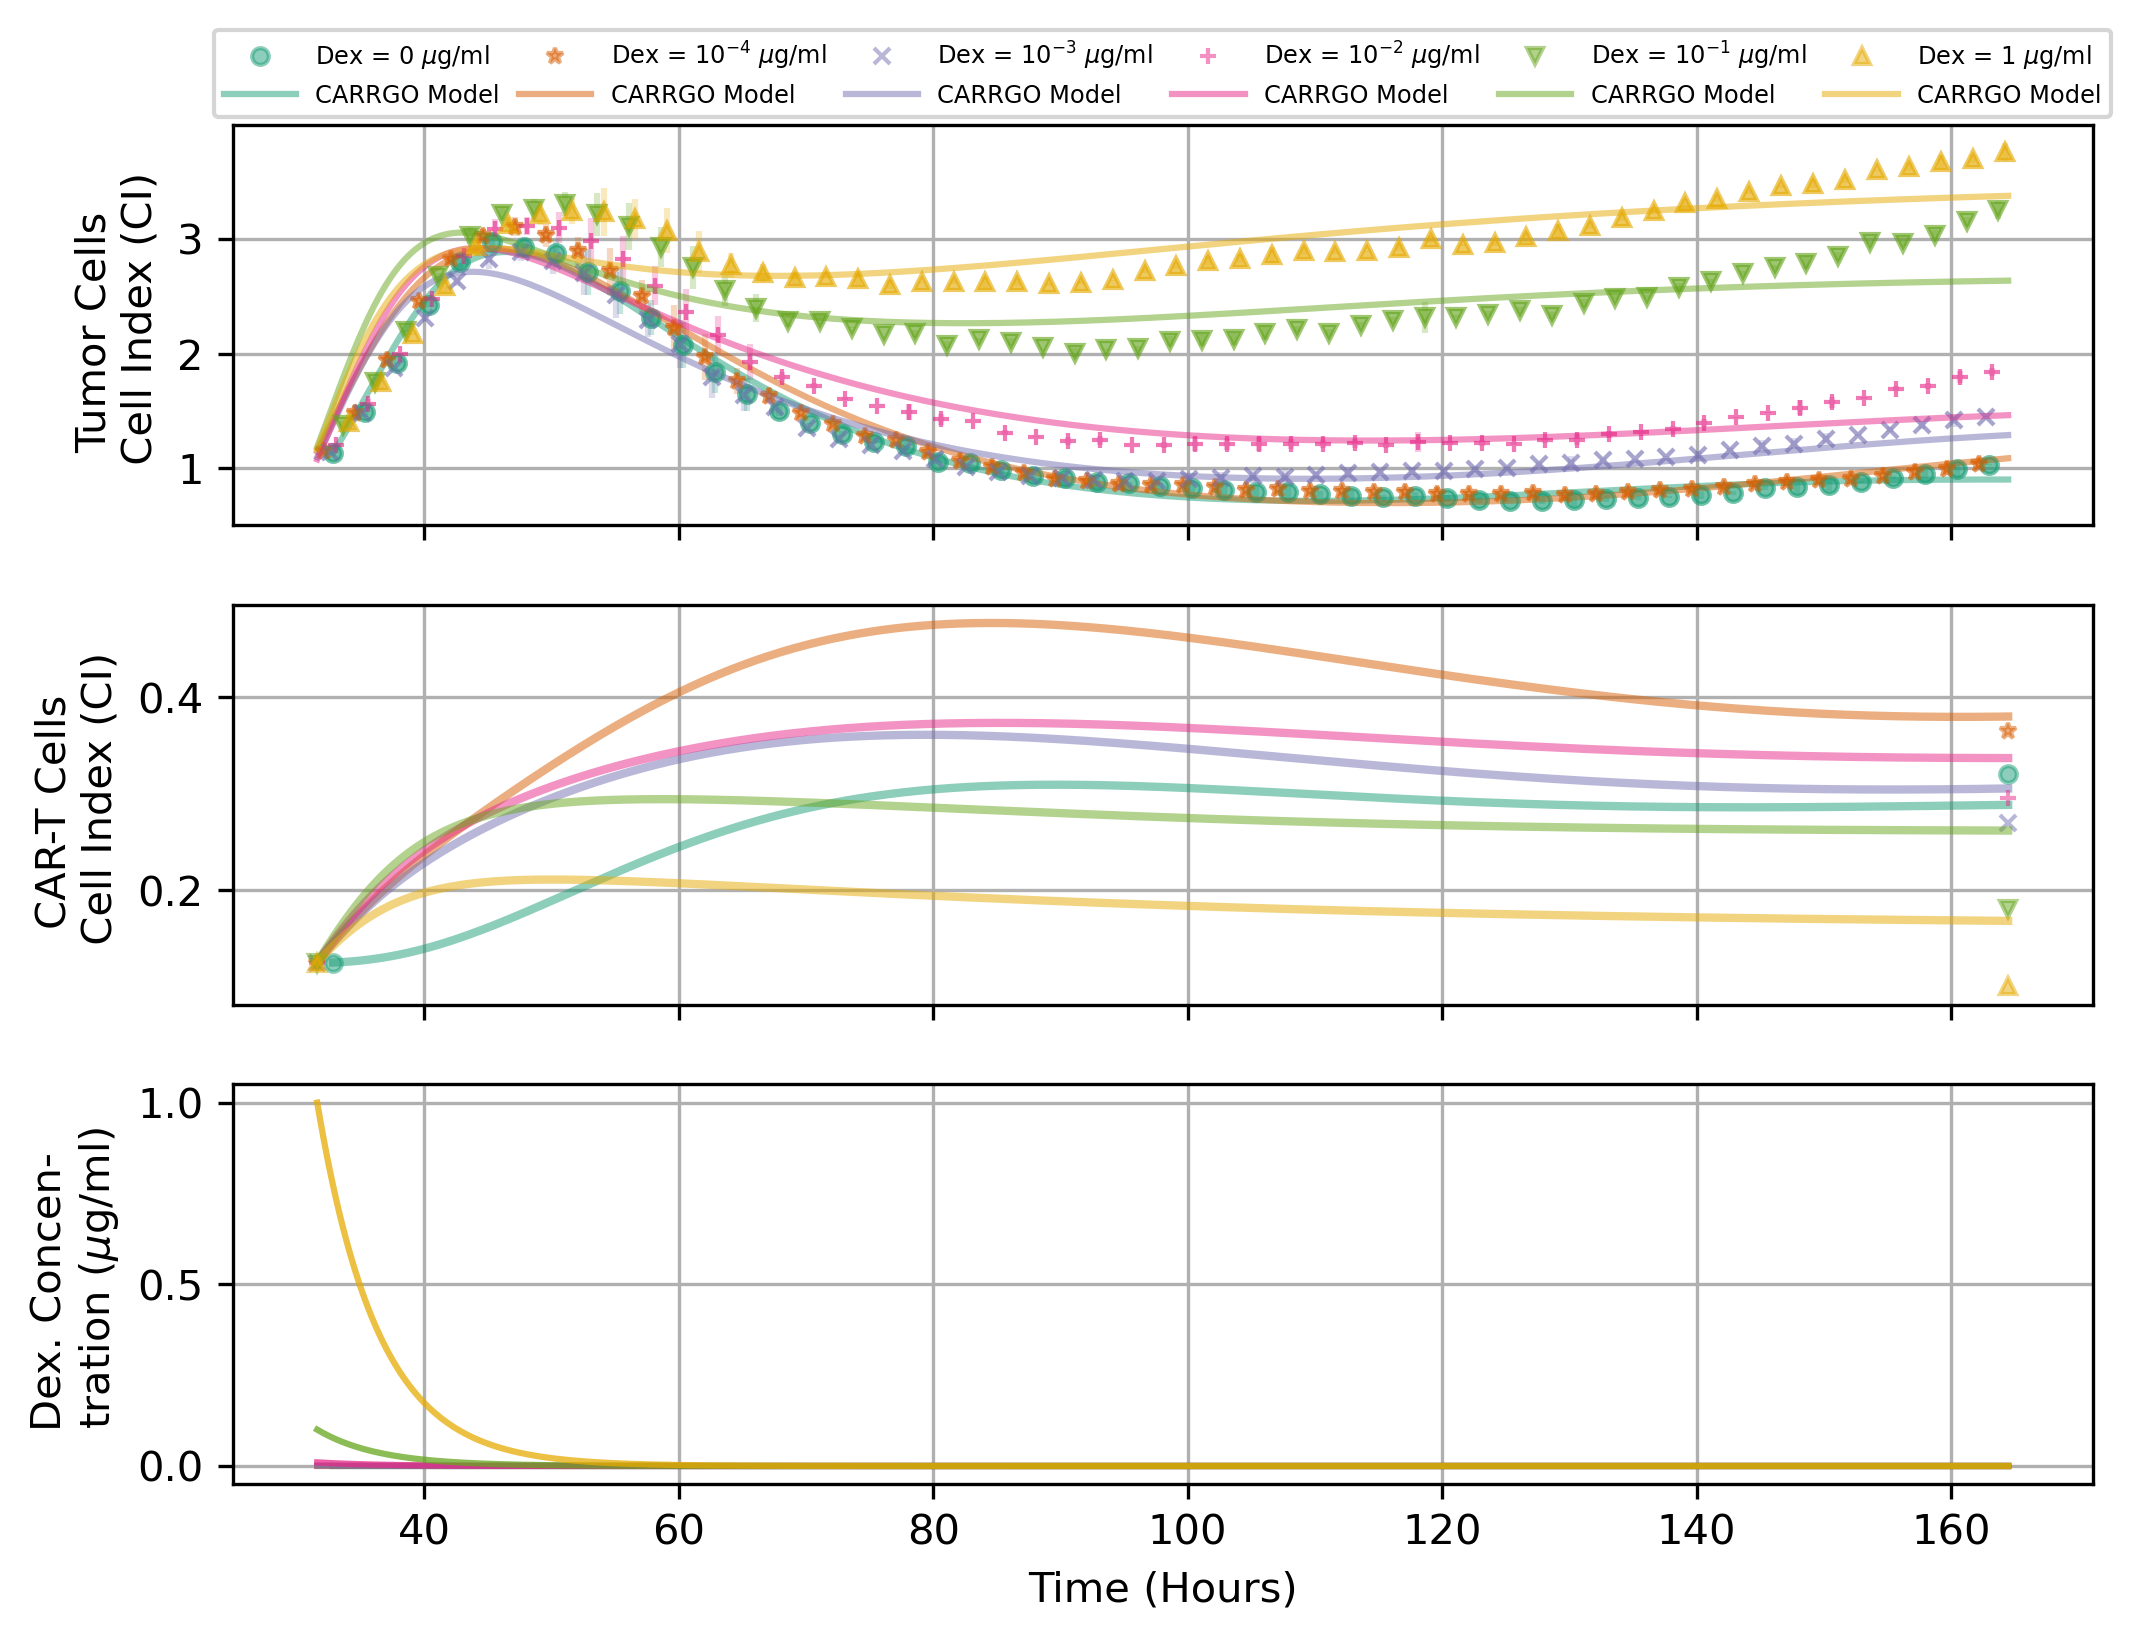

In [25]:
## Data/fit table accession for PBT030 (PBT 1) High CAR-T

#plt.figure()

plt.figure(num=None, figsize=(8, 6), dpi=300)
for i in range(6,12):
    
    print(i)
#    data_full = np.array(pbt_data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(pbt_1_2_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_1_2_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(pbt_1_2_data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to dxata_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    prediction = g_dt(t, x0, model_params)
    
    ax1 = plt.subplot(3,1,1)
#    plt.plot(t, data_fit[:,1], data_char_col[i], t, prediction[:,0], data_fit_char_col[i], 
#             label= 'Dex = '+str(dex_start_t)+'ug/ml')
    plt.errorbar(t[np.arange(2*(i-6),len(t), 10)], data_fit[:,1][np.arange(2*(i-6),len(t), 10)], 
                 data_sigma[:,1][np.arange(2*(i-6),len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None', alpha = 0.25, markersize = 4)

    plt.plot(t[np.arange(2*(i-6),len(t), 10)], data_fit[:,1][np.arange(2*(i-6),len(t), 10)],
             marker = data_char_sym[i], color = data_char_col[i], 
             linestyle = 'None',label= 'Dex = {} $\mu$g/ml'.format(fmt(dex_start_t)),
            alpha = 0.5, markersize = 4)
    plt.plot(t, prediction[:,0], linestyle = data_fit_char_sym[i], color = data_char_col[i], 
             label= 'CARRGO Model', alpha = 0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.legend(bbox_to_anchor=(-0.01,1.02,1.02,0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=6,
               fontsize = 'xx-small', markerscale = 1, handlelength = 3)
    ax1.grid(True)

#    plt.legend()

    plt.ylabel('Tumor Cells \n Cell Index (CI)')
#    plt.title('PBT128+ responder with dexamethasone gradient and CAR-T medium', y = 1.2)
#    plt.plot(t, prediction[:,0], '-', linewidth=2)
#    plt.plot(t, prediction[:,1], '-', linewidth=2)

    ax2 = plt.subplot(3,1,2, sharex = ax1)
    plt.plot(t, prediction[:,1], linestyle = data_fit_char_sym[i],
             color = data_char_col[i], linewidth=2, alpha = 0.5)
    plt.plot(t[-1], t_cell_fin_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.plot(t[0], t_cell_start_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('CAR-T Cells \n Cell Index (CI)')
    ax2.grid(True)
    

    ax3 = plt.subplot(3,1,3, sharex = ax1)
    plt.plot(t, dex_decay(t, dex_start_t, t[0]), linestyle = data_fit_char_sym[i], 
             color = data_char_col[i], label= 'Dex = '+str(dex_start_t)+'g/ml',
            alpha = 0.75)
    
    ax3.grid(True)
    plt.xlabel('Time (Hours)')
    plt.ylabel('Dex. Concen- \n tration ($\mu$g/ml)')
    plt.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))


plt.savefig(fname='/Users/abrummer/Desktop/pbt128+_cartmed.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()


In [26]:
## Data/fit table accession for PBT030 (PBT 1) High CAR-T

#plt.figure()

plt.figure(num=None, figsize=(8, 6), dpi=300)
for i in range(12,18):
    
    print(i)
#    data_full = np.array(pbt_data[['Time (Hour)', data_column_t[i]]])
    data_fit = np.array(pbt_1_2_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_1_2_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(pbt_1_2_data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to dxata_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    prediction = g_dt(t, x0, model_params)
    
    ax1 = plt.subplot(3,1,1)
#    plt.plot(t, data_fit[:,1], data_char_col[i], t, prediction[:,0], data_fit_char_col[i], 
#             label= 'Dex = '+str(dex_start_t)+'ug/ml')
    plt.errorbar(t[np.arange(2*(i-12),len(t), 10)], data_fit[:,1][np.arange(2*(i-12),len(t), 10)], 
                 data_sigma[:,1][np.arange(2*(i-12),len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None',alpha = 0.25, markersize = 4)

    plt.plot(t[np.arange(2*(i-12),len(t), 10)], data_fit[:,1][np.arange(2*(i-12),len(t), 10)], 
             marker = data_char_sym[i], color = data_char_col[i], 
             linestyle = 'None',label= 'Dex = {} $\mu$g/ml'.format(fmt(dex_start_t)),
            alpha = 0.5, markersize = 4)
    plt.plot(t, prediction[:,0], linestyle = data_fit_char_sym[i], color = data_char_col[i], 
             label= 'CARRGO Model', alpha = 0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.legend(bbox_to_anchor=(-0.01,1.02,1.02,0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=6,
               fontsize = 'xx-small', markerscale = 1, handlelength = 3)
    ax1.grid(True)

#    plt.legend()

    plt.ylabel('Tumor Cells \n Cell Index (CI)')
#    plt.title('PBT128+ responder with dexamethasone gradient and CAR-T low', y = 1.2)
#    plt.plot(t, prediction[:,0], '-', linewidth=2)
#    plt.plot(t, prediction[:,1], '-', linewidth=2)

    ax2 = plt.subplot(3,1,2, sharex = ax1)
    plt.plot(t, prediction[:,1], linestyle = data_fit_char_sym[i],
             color = data_char_col[i], linewidth=2, alpha = 0.5)
    plt.plot(t[-1], t_cell_fin_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.plot(t[0], t_cell_start_t, marker = data_char_sym[i], color = data_char_col[i],
            alpha = 0.5, markersize = 4)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('CAR-T Cells \n Cell Index (CI)')
    ax2.grid(True)
    

    ax3 = plt.subplot(3,1,3, sharex = ax1)
    plt.plot(t, dex_decay(t, dex_start_t, t[0]), linestyle = data_fit_char_sym[i], 
             color = data_char_col[i],label= 'Dex = '+str(dex_start_t)+'g/ml',
            alpha = 0.75)
    ax3.grid(True)
    plt.xlabel('Time (Hours)')
    plt.ylabel('Dex. Concen- \n tration ($\mu$g/ml)')
    plt.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0))


plt.savefig(fname='/Users/abrummer/Desktop/pbt128+_cartlow.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()


12
13
14
15
16


<ipython-input-26-4358462f987c>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3,1,1)
<ipython-input-26-4358462f987c>:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(3,1,2, sharex = ax1)
<ipython-input-26-4358462f987c>:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

17


In [11]:
### Plotting untreated growth against "least-most successful" treated cases.  Calculating cell kill from these 
### graphs

## Data/fit table accession for 
## PBT030 (PBT1), CAR T-cell high, and dex 1e-6g/ml
## PBT128+ (PBT2), CAR T-cell high, and dex 1e-9g/ml
## PBT138 (PBT4), CAR T-cell low, and dex 1e-9g/ml

## Initializing values.  Include no car t but matching dex in addition to zero treatment.

start_t = [105, 100, 110, 100, 100,
          115, 125, 115, 120, 120,
          115, 105, 105, 110, 110]
end_t = [487, 440, 652, 450, 652,
        250, 345, 275, 380, 652,
        666, 575, 666, 525, 666]
data_column_t = ['Y(A1,A2)', 'Y(B1,B2)', 'Y(A11,A12)', 'Y(B11,B12)', 'Y(C3,C4)',
                'Y(H1,H2)', 'Y(G1,G2)', 'Y(H5,H6)', 'Y(G5,G6)', 'Y(G9,G10)',
                'Y(H1,H2)', 'Y(E1,E2)', 'Y(H5,H6)', 'Y(E5,E6)', 'Y(E11,E12)']
sigma_column_t = 'SD' + re.split('Y',data_column_t[i])[1]
# DEFINE THESE USING fit_rows AND data_column_t AND DYNAMIC INDEXING.
#t_cell_start_t = [0,0,0]
#t_cell_fin_t = []
#dex_start_t = [0.00,1.00,0.10,0.01]
fit_rows = [0, 1, 8, 13, 14,
           24, 25, 29, 34, 36,
           48, 51, 53, 68, 71]

#data_char_col = ['mo','c*','gx','r+', 'mv', 'c^',
#                'mo','c*','gx','r+', 'mv', 'c^']
#data_char_col = ['m','c','g','r', 'm', 'c',
#                'm','c','g','r', 'm', 'c']
#data_char_col = ['#ffffcc', '#c7e9b4', '#7fcdbb', '#41b6c4', '#2c7fb8', '#253494',
#                '#ffffcc', '#c7e9b4', '#7fcdbb', '#41b6c4', '#2c7fb8', '#253494']
data_char_col = ['#7570b3', '#e7298a', '#66a61e', '#e6ab02', 'k',
                '#7570b3', '#e7298a', '#66a61e', '#e6ab02', 'k',
                '#7570b3', '#e7298a', '#66a61e', '#e6ab02', 'k']
data_char_col = ['k', '#1b9e77', 'grey', '#e6ab02', '#d95f02',
                'k', '#1b9e77', 'grey', '#7570b3', '#66a61e',
                'k', '#1b9e77', 'grey', '#7570b3', '#e6ab02']
data_char_sym = ['+', 'o', 'v', '^', '*',
                '+', 'o', 'v', 'x', '^',
                '+', 'o', 'v', 'x', '^']
#fit_char_col -> data_fit_char_col
#data_fit_char_col = ['k-','k--','k-.','k:', 'k-', 'k--',
#                    'k-','k--','k-.','k:', 'k-', 'k--']
data_fit_char_col = ['k','k','k','k', 'k', 'k',
                    'k','k','k','k', 'k', 'k',
                    'k','k','k','k', 'k', 'k']
data_fit_char_sym = ['-','--','-.',':', '-',
                    '-','--','-.',':', '-',
                    '-','--','-.',':', '-']

tcell_char_col = ['k-','k--','k-.','k:', 'k-', 'k--',
                 'k-','k--','k-.','k:', 'k-', 'k--']
tcell_fit_char_col = ['m-','c--','g-.','r:', 'm-', 'c--',
                     'm-','c--','g-.','r:', 'm-', 'c--']


<ipython-input-31-8327701eb4fb>:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3,1,1)
<ipython-input-31-8327701eb4fb>:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3,1,1)
<ipython-input-31-8327701eb4fb>:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be cr

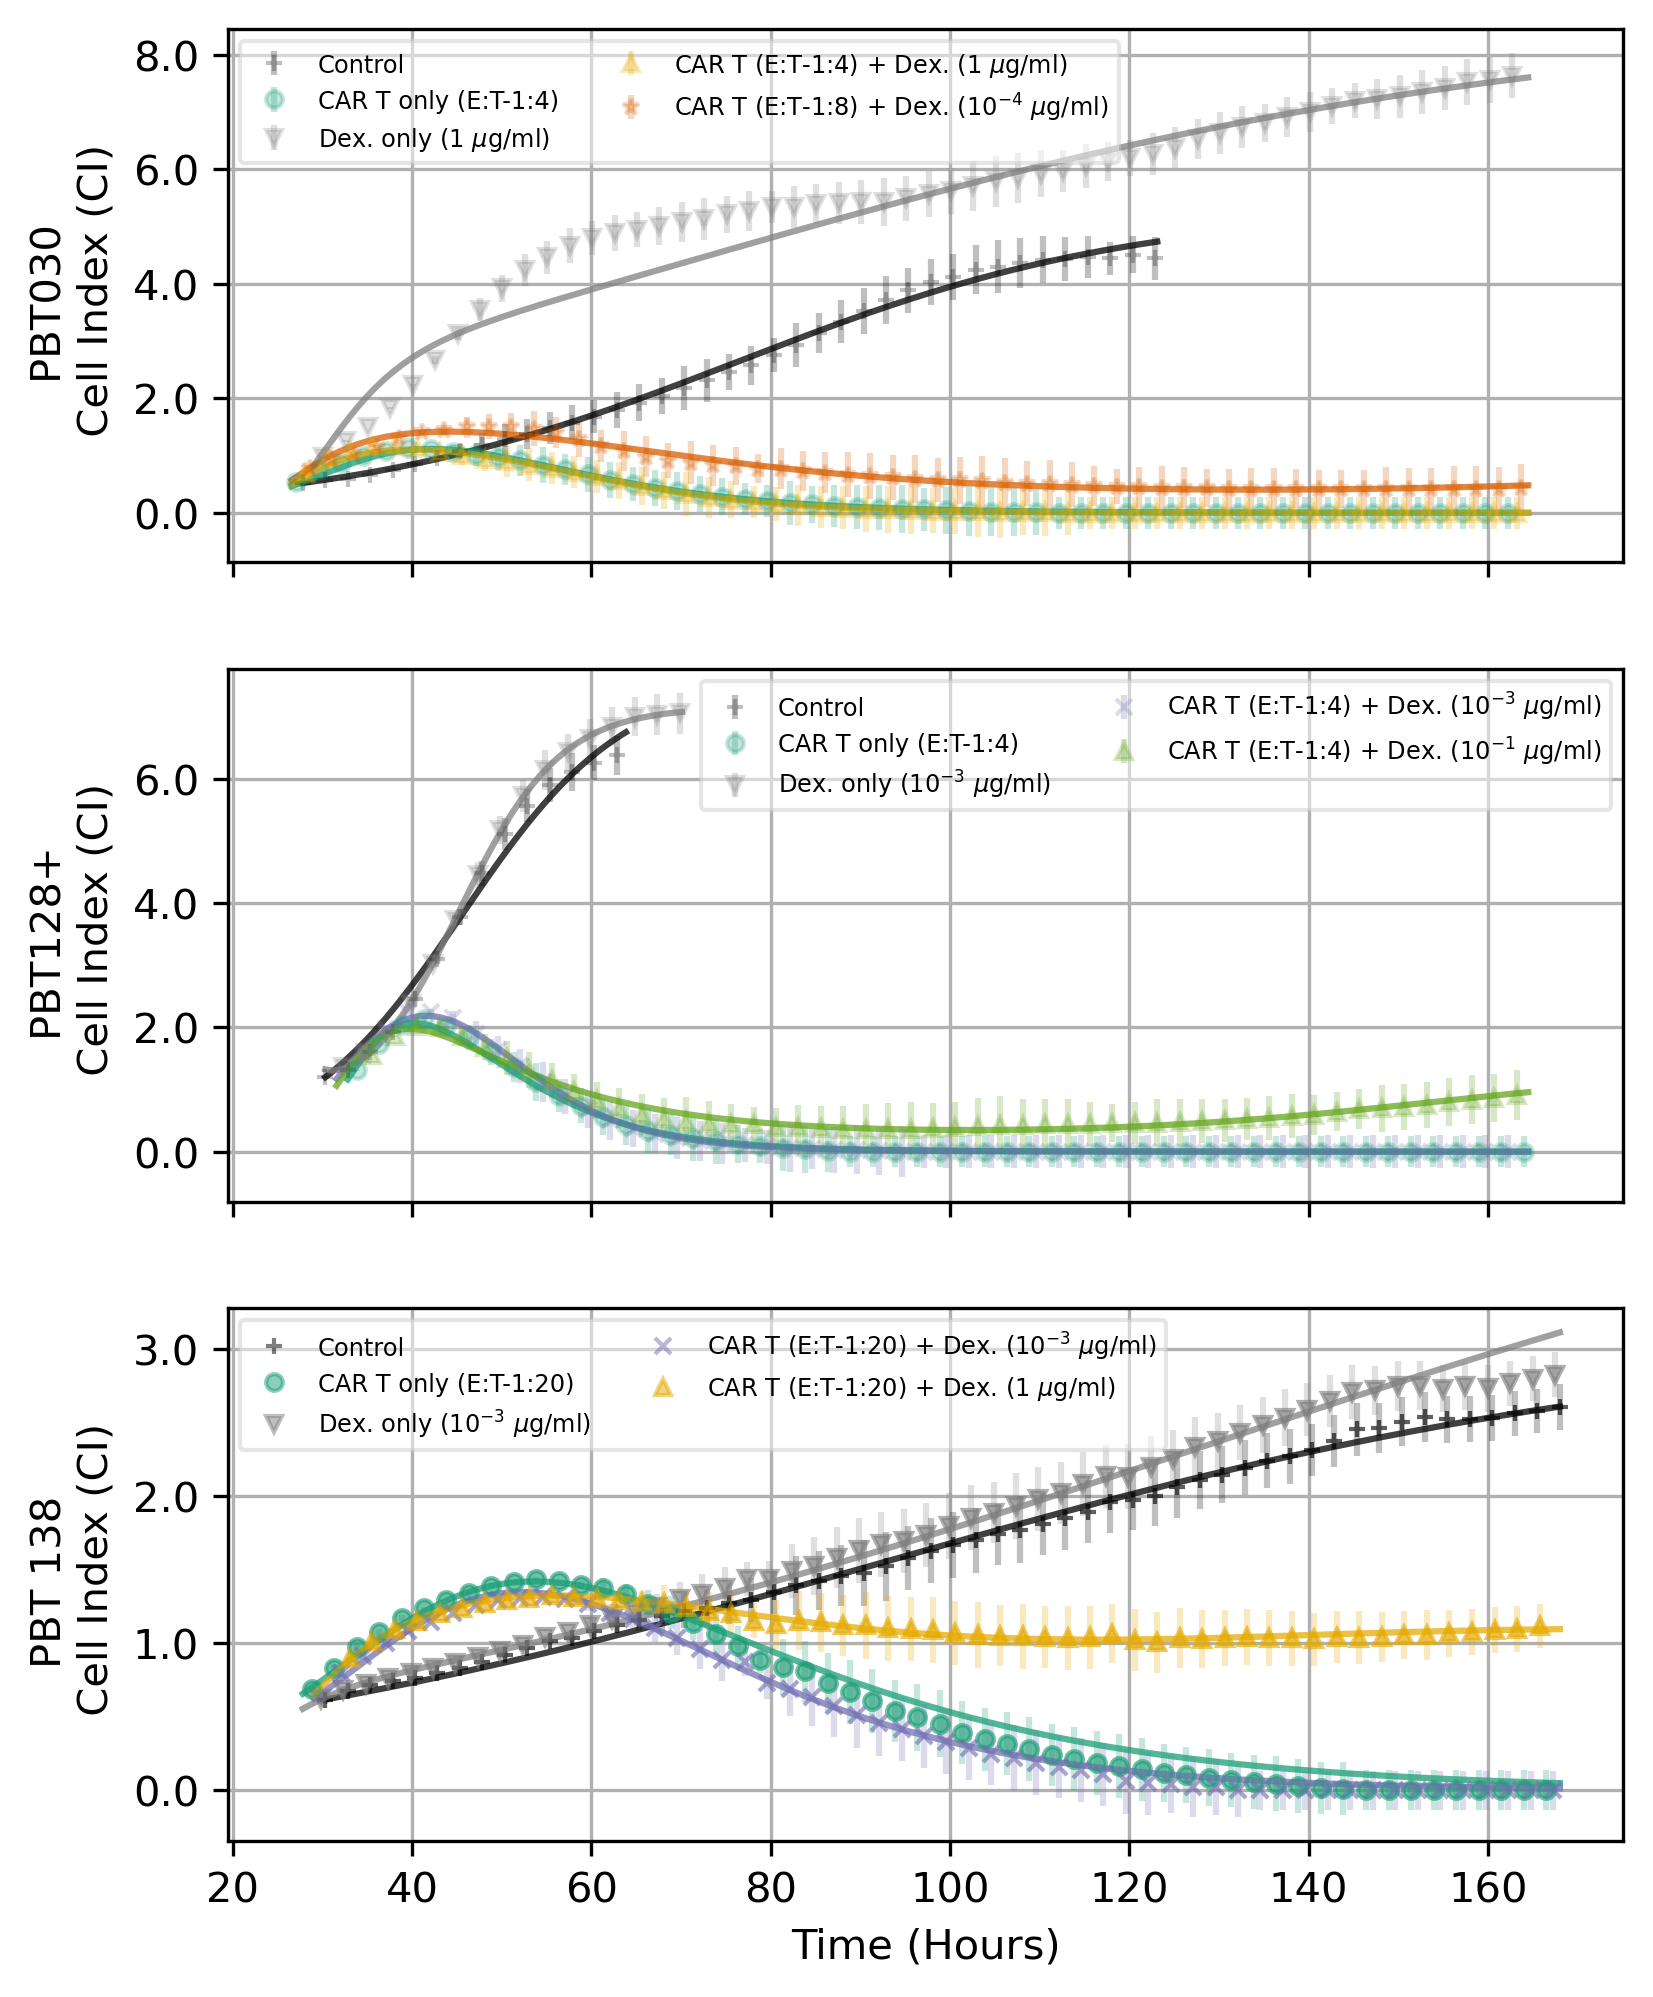

In [31]:
## Plotting untreated and treated together, three separate graphs.  Trying one alone first.


plt.figure(num=None, figsize=(6, 8), dpi=300)
for i in range(0,5):
    
    data_fit = np.array(pbt_1_2_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_1_2_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    
    if i >= 1:
        if end_t[i] != 652:
            new_time = np.array(pbt_1_2_data[['Time (Hour)']])[end_t[i]:652,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 652-end_t[i]
            # append zeros to dxata_fit equal to difference in end_t[i] and 652
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 652
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])

    prediction = g_dt(t, x0, model_params)
#    data_labels = ['Control', 'CAR T only ('+ str(t_cell_start_t) + 'CI)', 
#                  'Dex. only ({} $\mu$g/ml)'.format(fmt(dex_start_t)),
#                   'CAR T (' + str(t_cell_start_t) + 'CI) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t)), 
#                   'CAR T (' + str(t_cell_start_t) + 'CI) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t))]

    data_labels = ['Control', 'CAR T only (E:T-1:4)', 
                  'Dex. only ({} $\mu$g/ml)'.format(fmt(dex_start_t)),
                   'CAR T (E:T-1:4) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t)), 
                   'CAR T (E:T-1:8) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t))]

    ax1 = plt.subplot(3,1,1)
    plt.errorbar(t[np.arange(2*i,len(t), 10)], data_fit[:,1][np.arange(2*i,len(t), 10)], 
                 data_sigma[:,1][np.arange(2*i,len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None', label= data_labels[i],
                 alpha = 0.25, markersize = 4)
#    plt.plot(t[np.arange(2*i,len(t), 10)], data_fit[:,1][np.arange(2*i,len(t), 10)],
#             marker = data_char_sym[i], color = data_char_col[i], 
#             linestyle = 'None', alpha = 0.5, markersize = 4,
#             label= data_labels[i])
    plt.plot(t, prediction[:,0], linestyle = '-', color = data_char_col[i], 
             alpha = 0.75)
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    legend = ax1.legend(bbox_to_anchor=(0, 1), loc = "upper left", ncol = 2, fontsize = 'xx-small',
               markerscale = 1)
    legend.get_frame().set_alpha(0.5)
    legend.get_frame().set_facecolor((1, 1, 1, 0.9))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.ylabel('PBT030 \n Cell Index (CI)')
    plt.grid(True)

for i in range(5,10):
    
    data_fit = np.array(pbt_1_2_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_1_2_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    if i == 6 or i == 8:
        if end_t[i] != 652:
            new_time = np.array(pbt_1_2_data[['Time (Hour)']])[end_t[i]:652,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 652-end_t[i]
            # append zeros to dxata_fit equal to difference in end_t[i] and 652
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 652
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    prediction = g_dt(t, x0, model_params)
#    data_labels = ['Control', 'CAR T only ('+ str(t_cell_start_t) + 'CI)', 
#                  'Dex. only ({} $\mu$g/ml)'.format(fmt(dex_start_t)),
#                   'CAR T (' + str(t_cell_start_t) + 'CI) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t)), 
#                  'CAR T (' + str(t_cell_start_t) + 'CI) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t))]

    data_labels = ['Control', 'CAR T only (E:T-1:4)', 
                  'Dex. only ({} $\mu$g/ml)'.format(fmt(dex_start_t)),
                   'CAR T (E:T-1:4) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t)), 
                  'CAR T (E:T-1:4) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t))]

    
    ax2 = plt.subplot(3,1,2, sharex = ax1)
    plt.errorbar(t[np.arange(4*(i-5),len(t), 10)], data_fit[:,1][np.arange(4*(i-5),len(t), 10)], 
                 data_sigma[:,1][np.arange(4*(i-5),len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None', label= data_labels[i-5],
                 alpha = 0.25, markersize = 4)
#    plt.plot(t[np.arange(4*(i-5),len(t), 10)], data_fit[:,1][np.arange(4*(i-5),len(t), 10)], 
#             marker = data_char_sym[i], color = data_char_col[i], markersize = 4,
#             linestyle = 'None', alpha = 0.5,
#             label= data_labels[i-5])
    plt.plot(t, prediction[:,0], linestyle = '-', color = data_char_col[i], 
             alpha = 0.75)
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    legend = ax2.legend(bbox_to_anchor=(1, 1), loc = "upper right", ncol = 2, fontsize = 'xx-small',
               markerscale = 1)
    legend.get_frame().set_alpha(0.5)
    legend.get_frame().set_facecolor((1, 1, 1, 0.9))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.ylabel('PBT128+ \n Cell Index (CI)')
    plt.grid(True)

    
for i in range(10,15):
    data_fit = np.array(pbt_3_4_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt_3_4_data[['Time (Hour)', sigma_column_t]])[start_t[i]:end_t[i],:]
    
    if i >= 10:
        if end_t[i] != 666:
            new_time = np.array(pbt_3_4_data[['Time (Hour)']])[end_t[i]:666,:]
            new_sigma = np.mean(data_sigma[:,1])
            extend_length = 666-end_t[i]
            # append zeros to dxata_fit equal to difference in end_t[i] and 666
            data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), axis = 1), axis = 0)        
            # append average sigma to data_sigma equal to difference in end_t[i] and 666
            data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1), axis = 1), axis = 0)


    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val','c0_val',
                                           'kappac1_val','kappac2_val','theta_val',
                                           'c3_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    dex_start_t = np.array(pbt_full_fits[['dex_.ug.ml.']])[fit_rows[i],0]*1000000
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    prediction = g_dt(t, x0, model_params)
#    data_labels = ['Control', 'CAR T only ('+ str(t_cell_start_t) + 'CI)', 
#                  'Dex. only ({} $\mu$g/ml)'.format(fmt(dex_start_t)),
#                   'CAR T (' + str(t_cell_start_t) + 'CI) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t)), 
#                  'CAR T (' + str(t_cell_start_t) + 'CI) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t))]

    data_labels = ['Control', 'CAR T only (E:T-1:20)', 
                  'Dex. only ({} $\mu$g/ml)'.format(fmt(dex_start_t)),
                   'CAR T (E:T-1:20) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t)), 
                  'CAR T (E:T-1:20) + Dex. ({} $\mu$g/ml)'.format(fmt(dex_start_t))]

    
    ax3 = plt.subplot(3,1,3, sharex = ax1)
    plt.errorbar(t[np.arange(4*(i-10),len(t), 10)], data_fit[:,1][np.arange(4*(i-10),len(t), 10)], 
                 data_sigma[:,1][np.arange(4*(i-10),len(t), 10)], marker = data_char_sym[i], color = data_char_col[i], 
                 linestyle = 'None', alpha = 0.25, markersize = 4)
    plt.plot(t[np.arange(4*(i-10),len(t),10)], data_fit[:,1][np.arange(4*(i-10),len(t),10)], 
             marker = data_char_sym[i], color = data_char_col[i], 
             linestyle = 'None', alpha = 0.5,
             label= data_labels[i-10], markersize = 4)
    plt.plot(t, prediction[:,0], linestyle = '-', color = data_char_col[i], 
             alpha = 0.75)
    
    legend = ax3.legend(bbox_to_anchor=(0, 1), loc = "upper left", ncol = 2, fontsize = 'xx-small',
               markerscale = 1)
    legend.get_frame().set_alpha(0.5)
    legend.get_frame().set_facecolor((1, 1, 1, 0.9))
    ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.ylabel('PBT 138 \n Cell Index (CI)')
    plt.xlabel('Time (Hours)')
    plt.grid(True)


plt.savefig(fname='/Users/abrummer/Desktop/growth_kill_comparison.png', dpi = 300,
            bbox_inches = 'tight')
plt.show()